<a href="https://colab.research.google.com/github/sergioGarcia91/BucaramangaSeismicNest_ML/blob/main/ML_SismosNido_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook to calculate the dip direction and inclination of the plane obtained from the linear model considering only events at depths greater than 100 km.

# Start

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.cluster import DBSCAN

In [ ]:
pathDatos = '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/Catalogos/'

In [ ]:
# Se carga el catalogo de los eventos de prof mayores a 100 km
df_todos = pd.read_csv(pathDatos+'df_Total_1994_2024.csv')
df_todos['Date-Time'] = pd.to_datetime(df_todos['Date-Time'], yearfirst=True)
df_todos.dropna(inplace=True)
df_todos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 148910 entries, 0 to 148985
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   FECHA                   148910 non-null  object        
 1   HORA_UTC                148910 non-null  object        
 2   LATITUD (grados)        148910 non-null  float64       
 3   LONGITUD (grados)       148910 non-null  float64       
 4   PROFUNDIDAD (Km)        148910 non-null  float64       
 5   MAGNITUD Ml             148910 non-null  float64       
 6   ERROR LATITUD (Km)      148910 non-null  float64       
 7   ERROR LONGITUD (Km)     148910 non-null  float64       
 8   ERROR PROFUNDIDAD (Km)  148910 non-null  float64       
 9   Date-Time               148910 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(7), object(2)
memory usage: 12.5+ MB


In [ ]:
df_Filtrado_100km = df_todos[df_todos['PROFUNDIDAD (Km)'] >= 100]
df_Filtrado_100km_25ml = df_Filtrado_100km[df_Filtrado_100km['MAGNITUD Ml'] >= 2.5]
df_Filtrado_100km_25ml

FECHA  HORA_UTC  LATITUD (grados)  LONGITUD (grados)  \
0       1994-01-01  00:06:37             6.839            -72.950   
1       1994-01-01  08:17:30             6.877            -72.912   
2       1994-01-02  01:55:17             6.806            -72.898   
3       1994-01-02  04:49:35             6.898            -73.095   
4       1994-01-02  05:55:47             6.736            -73.201   
...            ...       ...               ...                ...   
148967  2024-02-29  07:54:00             6.776            -73.179   
148977  2024-02-29  11:57:42             6.778            -73.196   
148979  2024-02-29  16:19:24             6.772            -73.138   
148984  2024-02-29  22:13:41             6.769            -73.076   
148985  2024-02-29  23:17:12             6.773            -73.124   

        PROFUNDIDAD (Km)  MAGNITUD Ml  ERROR LATITUD (Km)  \
0                 158.60          3.7              15.800   
1                 166.60          4.1              14.700   
2                 150.00          3.0              12.800   
3                 150.00          3.1               8.300   
4                 150.00          5.3              17.100   
...                  ...          ...                 ...   
148967            144.41          2.5               2.639   
148977            140.90          2.9               2.538   
148979            140.43          2.6               2.438   
148984            146.99          2.9               1.851   
148985            147.52          2.5               0.778   

        ERROR LONGITUD (Km)  ERROR PROFUNDIDAD (Km)           Date-Time  
0                    17.200                   19.50 1994-01-01 00:06:37  
1                    19.900                   16.20 1994-01-01 08:17:30  
2                    15.800                   17.80 1994-01-02 01:55:17  
3                     8.700                   11.30 1994-01-02 04:49:35  
4                    18.000                   24.70 1994-01-02 05:55:47  
...                     ...                     ...                 ...  
148967                3.743                    4.77 2024-02-29 07:54:00  
148977                3.365                    4.62 2024-02-29 11:57:42  
148979                3.885                    4.56 2024-02-29 16:19:24  
148984                3.142                    4.15 2024-02-29 22:13:41  
148985                0.778                    0.90 2024-02-29 23:17:12  

[31899 rows x 10 columns]

In [ ]:
puntosSismos = gpd.points_from_xy(df_Filtrado_100km_25ml['LONGITUD (grados)'],
                                  df_Filtrado_100km_25ml['LATITUD (grados)'],
                                  crs='epsg:4326')
puntosSismos

<GeometryArray>
[ <POINT (-72.95 6.839)>, <POINT (-72.912 6.877)>, <POINT (-72.898 6.806)>,
 <POINT (-73.095 6.898)>, <POINT (-73.201 6.736)>, <POINT (-73.016 6.713)>,
 <POINT (-73.039 6.813)>, <POINT (-73.023 6.786)>, <POINT (-73.135 7.053)>,
 <POINT (-73.049 6.783)>,
 ...
 <POINT (-73.162 6.763)>, <POINT (-73.153 6.803)>, <POINT (-73.166 6.803)>,
  <POINT (-73.192 6.82)>, <POINT (-73.179 6.801)>, <POINT (-73.179 6.776)>,
 <POINT (-73.196 6.778)>, <POINT (-73.138 6.772)>, <POINT (-73.076 6.769)>,
 <POINT (-73.124 6.773)>]
Length: 31899, dtype: geometry

<Axes: >

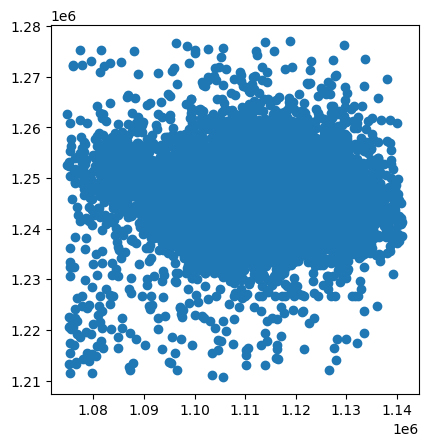

In [ ]:
gdf = gpd.GeoDataFrame(data= df_Filtrado_100km_25ml, geometry=puntosSismos)
gdf.to_crs(epsg='3116', inplace=True)
gdf.plot()

In [ ]:
gdf['X'] = gdf.get_coordinates()['x']
gdf['Y'] = gdf.get_coordinates()['y']
gdf['Z'] = gdf['PROFUNDIDAD (Km)'] * 1000
gdf.head()

FECHA  HORA_UTC  LATITUD (grados)  LONGITUD (grados)  \
0  1994-01-01  00:06:37             6.839            -72.950   
1  1994-01-01  08:17:30             6.877            -72.912   
2  1994-01-02  01:55:17             6.806            -72.898   
3  1994-01-02  04:49:35             6.898            -73.095   
4  1994-01-02  05:55:47             6.736            -73.201   

   PROFUNDIDAD (Km)  MAGNITUD Ml  ERROR LATITUD (Km)  ERROR LONGITUD (Km)  \
0             158.6          3.7                15.8                 17.2   
1             166.6          4.1                14.7                 19.9   
2             150.0          3.0                12.8                 15.8   
3             150.0          3.1                 8.3                  8.7   
4             150.0          5.3                17.1                 18.0   

   ERROR PROFUNDIDAD (Km)           Date-Time  \
0                    19.5 1994-01-01 00:06:37   
1                    16.2 1994-01-01 08:17:30   
2                    17.8 1994-01-02 01:55:17   
3                    11.3 1994-01-02 04:49:35   
4                    24.7 1994-01-02 05:55:47   

                          geometry             X             Y         Z  
0  POINT (1124634.322 1248167.015)  1.124634e+06  1.248167e+06  158600.0  
1  POINT (1128825.175 1252380.301)  1.128825e+06  1.252380e+06  166600.0  
2  POINT (1130392.089 1244530.574)  1.130392e+06  1.244531e+06  150000.0  
3  POINT (1108591.040 1254657.620)  1.108591e+06  1.254658e+06  150000.0  
4  POINT (1096907.050 1236717.171)  1.096907e+06  1.236717e+06  150000.0

# Hist2D

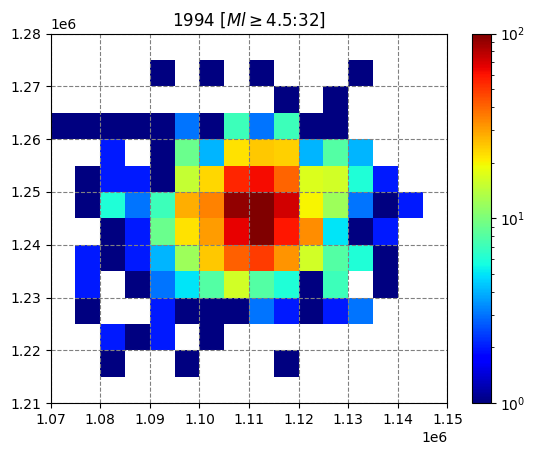

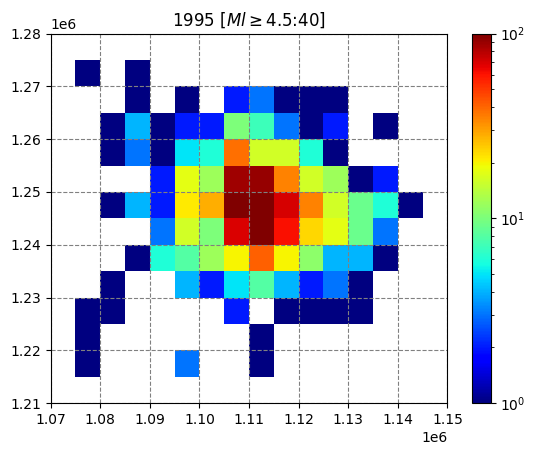

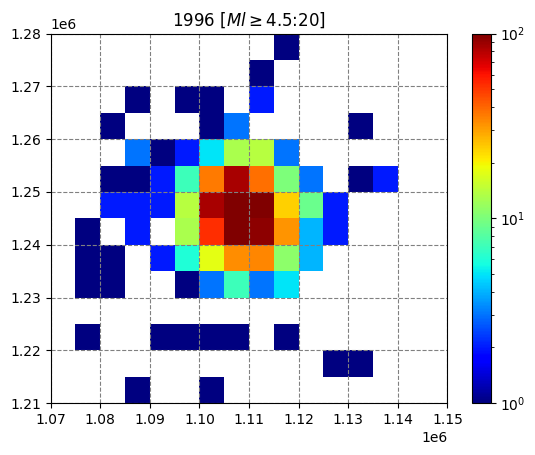

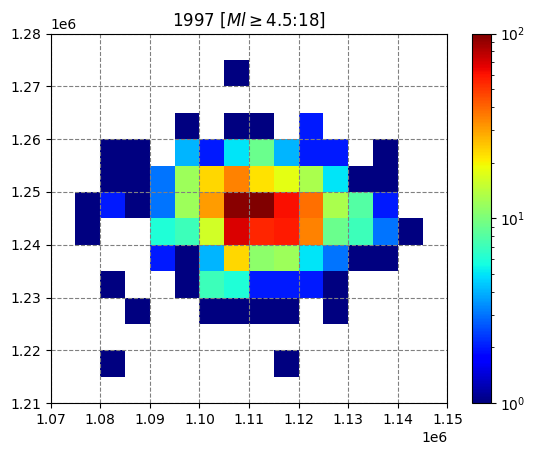

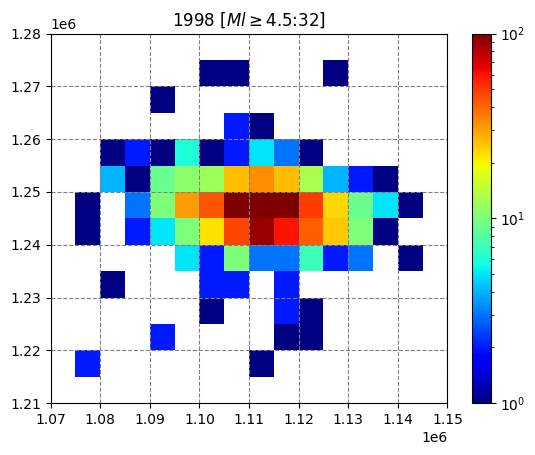

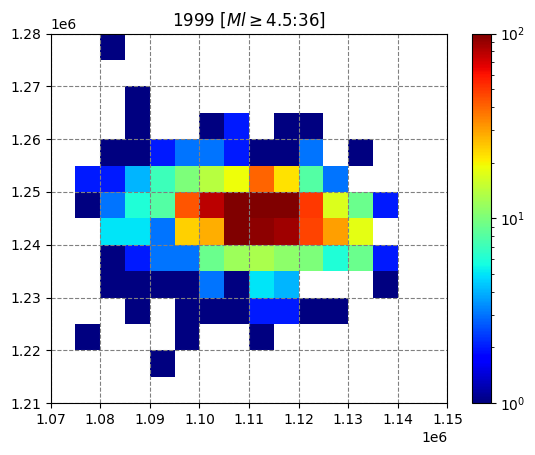

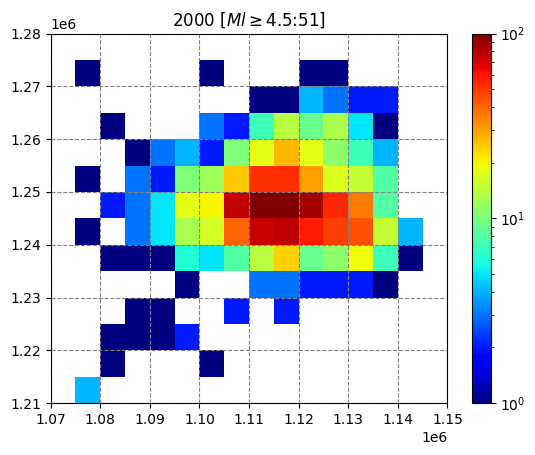

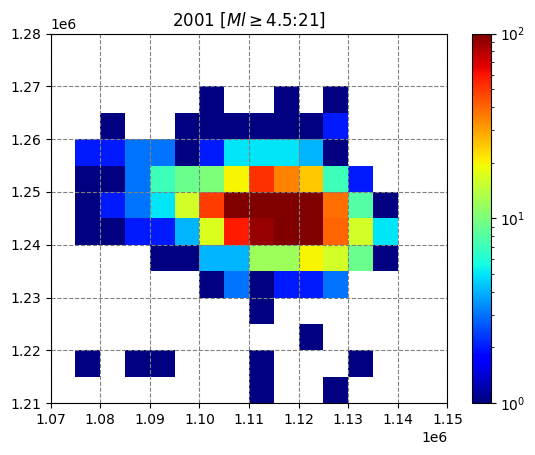

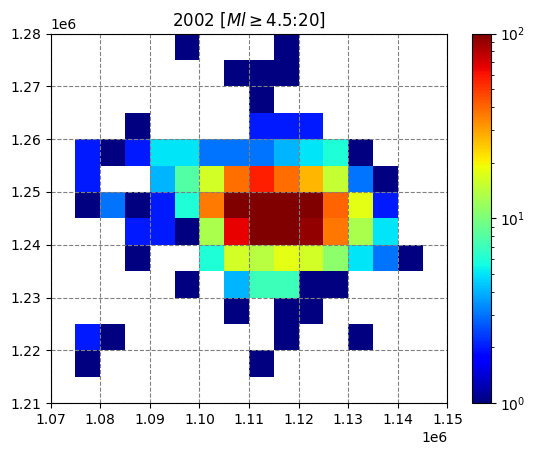

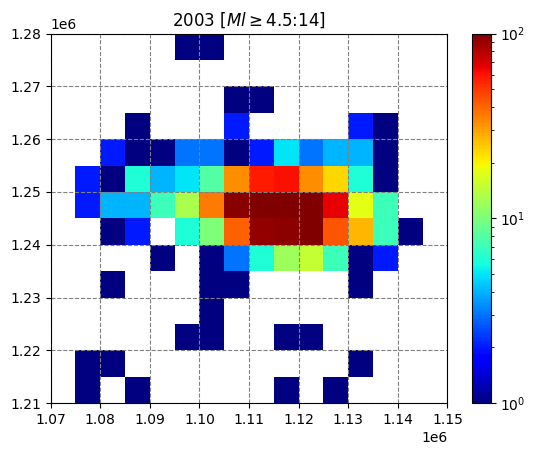

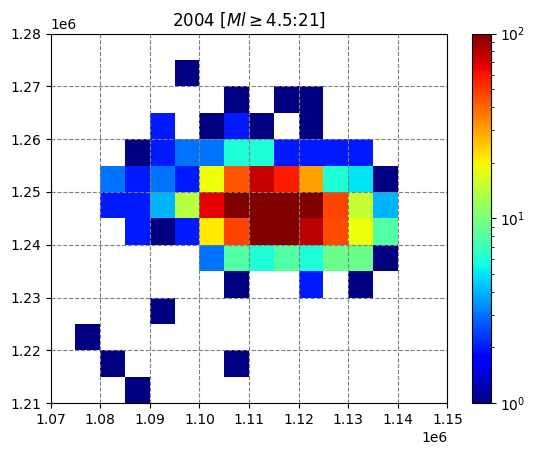

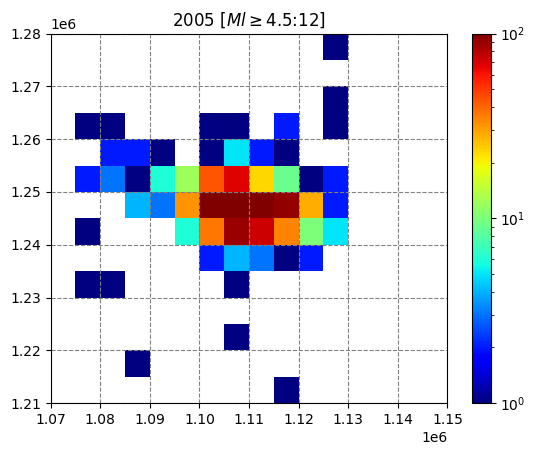

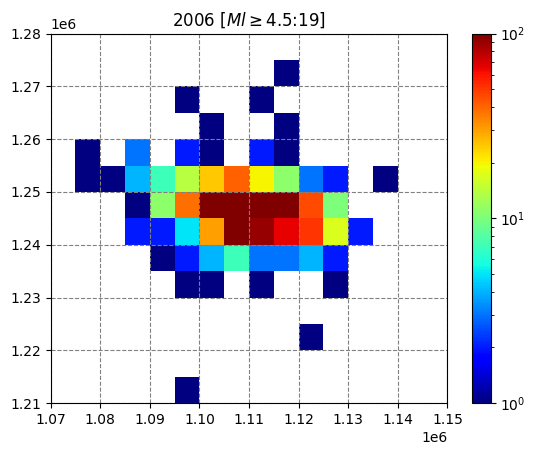

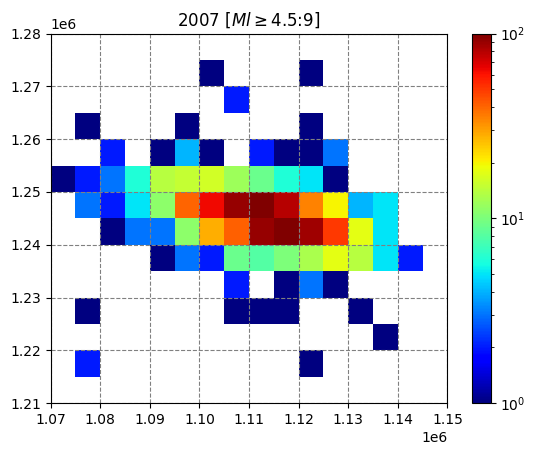

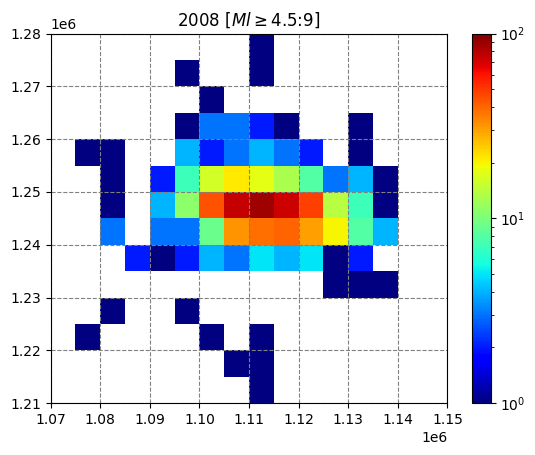

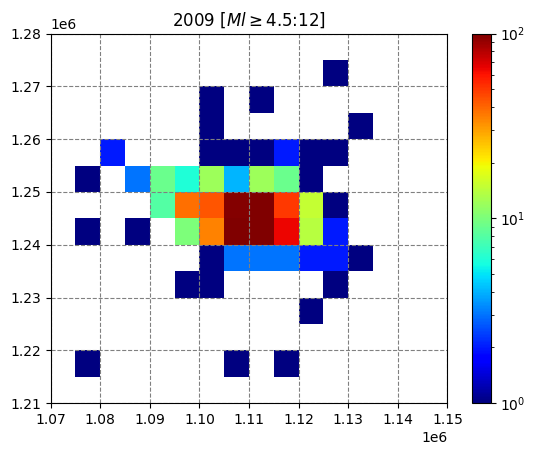

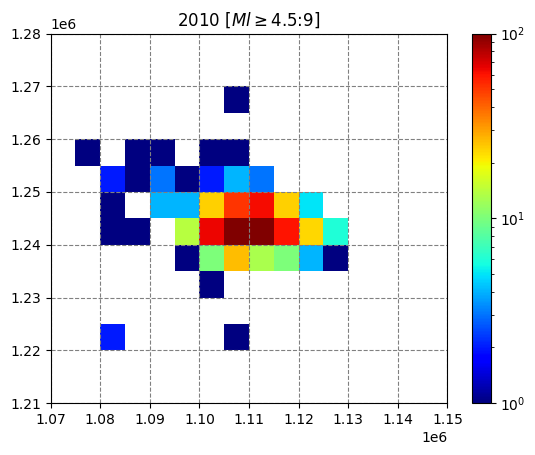

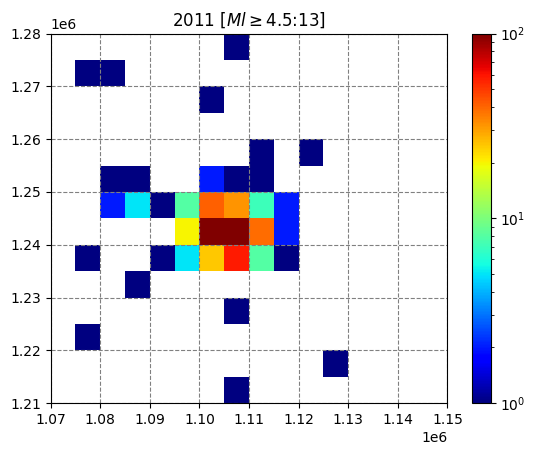

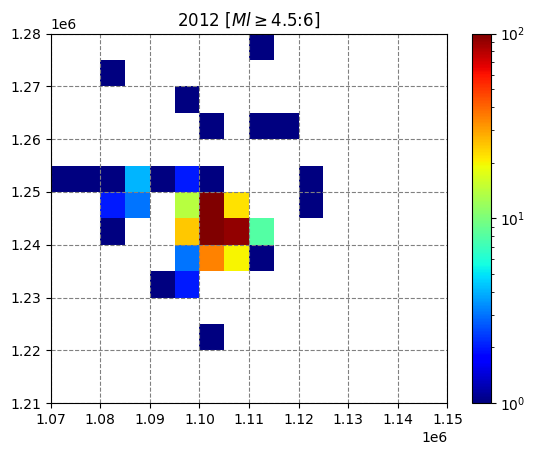

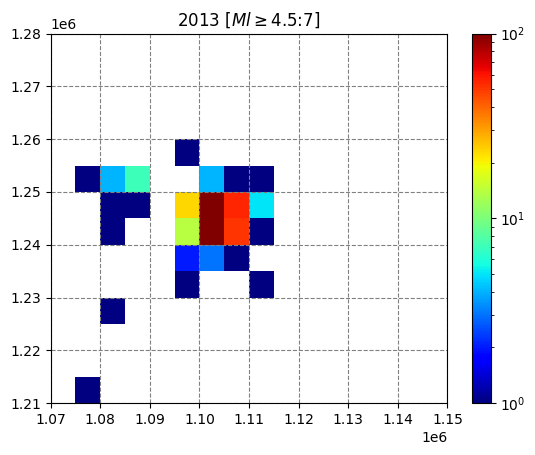

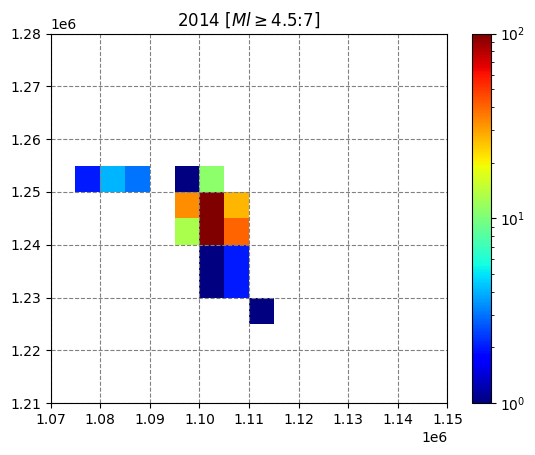

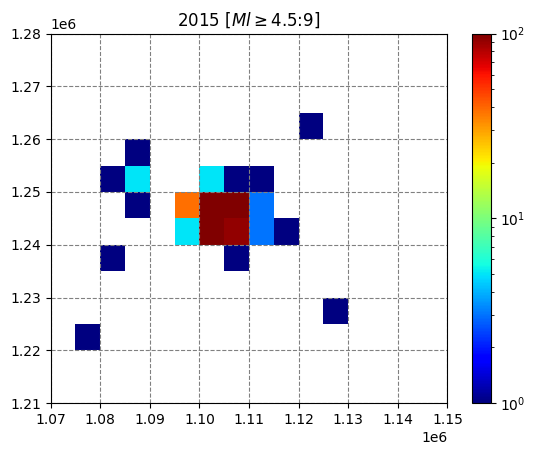

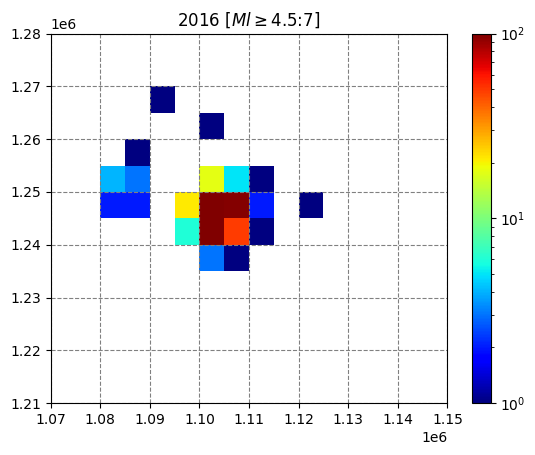

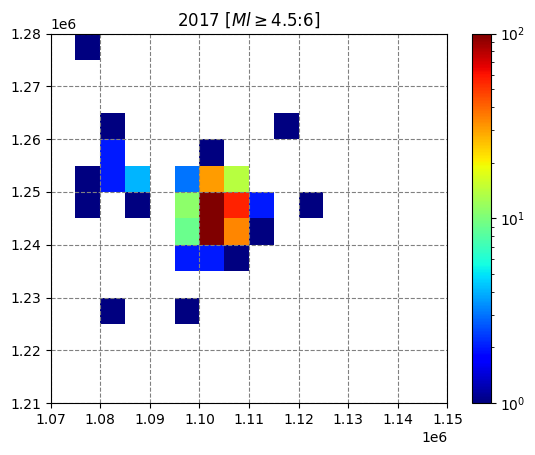

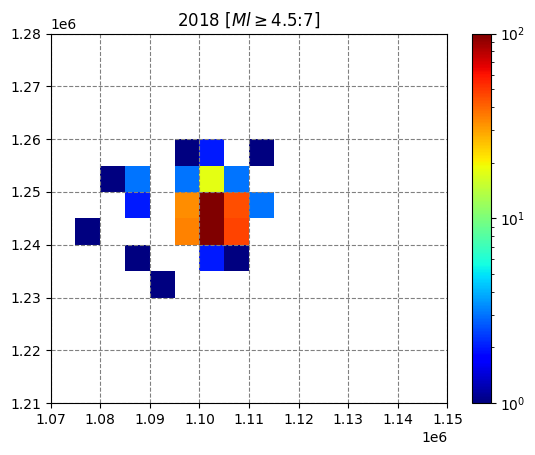

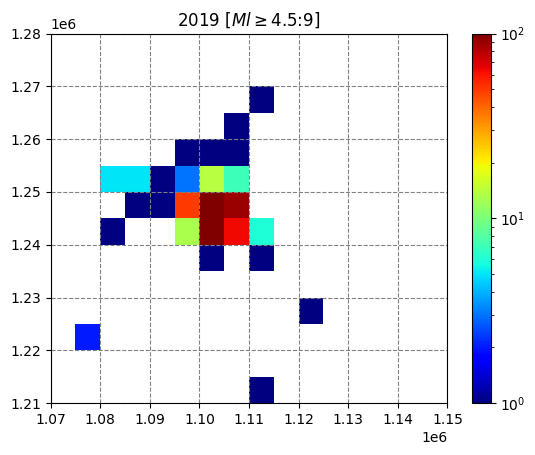

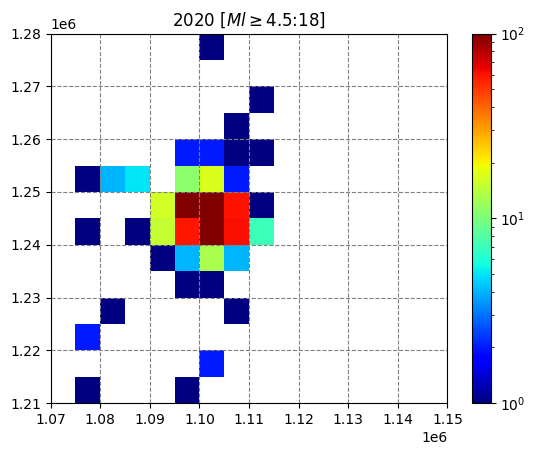

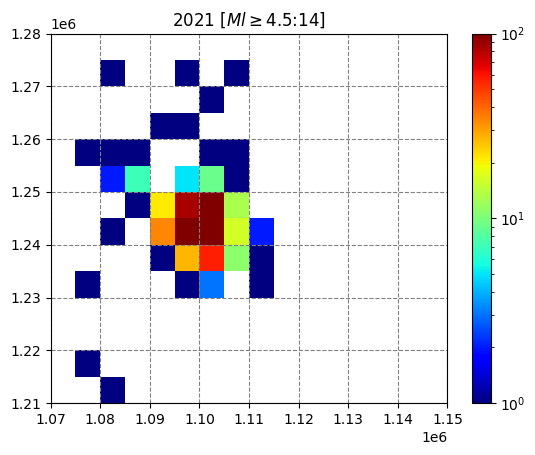

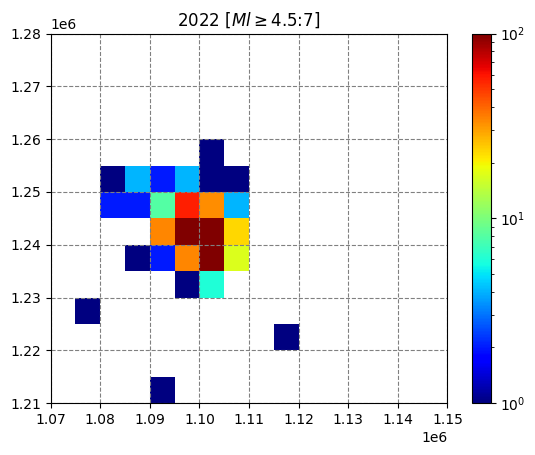

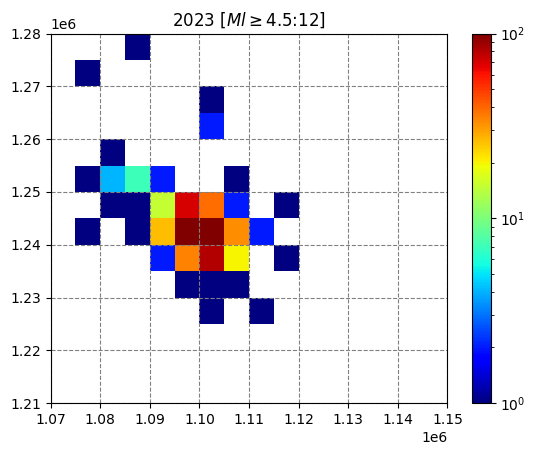

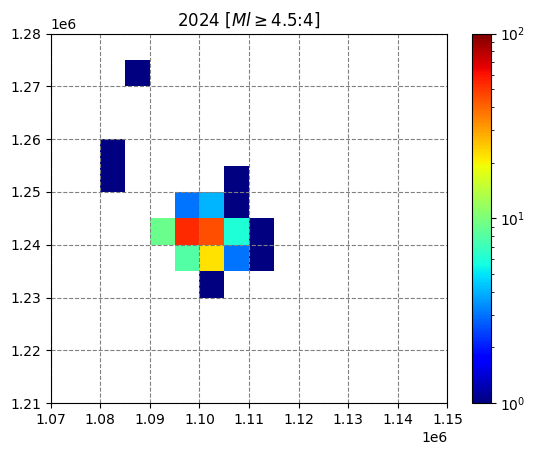

In [ ]:
years = np.arange(1994, 2025,1)

# [[xmin, xmax], [ymin, ymax]]
rangeHist2D = np.array([[1070000, 1150000],
                        [1210000, 1280000]])

# nx, ny
binsHist2d = [16, 14]

for year in years:
  gdf2 = gdf[gdf['Date-Time'].dt.year == year].copy()
  X = gdf2['X'].to_numpy()
  y = gdf2['Y'].to_numpy()
  nEventos = np.sum(gdf2['MAGNITUD Ml'] >= 4.5)

  plt.figure()
  plt.hist2d(X,
             y,
             bins=binsHist2d,
             range=rangeHist2D,
             norm='log', # "linear", "log", "symlog", "logit"
             vmin=1,
             vmax=100,
             cmap='jet')
  plt.grid(ls='--', c='grey')
  plt.colorbar()
  plt.title(f'{year} [$Ml\geq4.5$:{nEventos}]')
  plt.show()
  print('\n')

# DBSCAN

In [ ]:
for year in years:
  gdf2 = gdf[gdf['Date-Time'].dt.year == year].copy()

  clustering = DBSCAN(eps=5000, min_samples=15).fit(gdf2[['X', 'Y', 'Z']].to_numpy())
  print('##### \n', year)
  print(np.unique(clustering.labels_))



##### 
 1994
[-1  0]
##### 
 1995
[-1  0]
##### 
 1996
[-1  0]
##### 
 1997
[-1  0]
##### 
 1998
[-1  0]
##### 
 1999
[-1  0]
##### 
 2000
[-1  0]
##### 
 2001
[-1  0]
##### 
 2002
[-1  0]
##### 
 2003
[-1  0]
##### 
 2004
[-1  0]
##### 
 2005
[-1  0]
##### 
 2006
[-1  0]
##### 
 2007
[-1  0]
##### 
 2008
[-1  0]
##### 
 2009
[-1  0]
##### 
 2010
[-1  0]
##### 
 2011
[-1  0]
##### 
 2012
[-1  0]
##### 
 2013
[-1  0]
##### 
 2014
[-1  0]
##### 
 2015
[-1  0]
##### 
 2016
[-1  0]
##### 
 2017
[-1  0]
##### 
 2018
[-1  0]
##### 
 2019
[-1  0]
##### 
 2020
[-1  0]
##### 
 2021
[-1  0]
##### 
 2022
[-1  0]
##### 
 2023
[-1  0]


######## 
  1994
R2 RegLin 0.26047932551095465
R2 Ransac -0.0067902733254396885
R2 Ridge 0.2604793255109551
R2 Lasso 0.2604793255109539


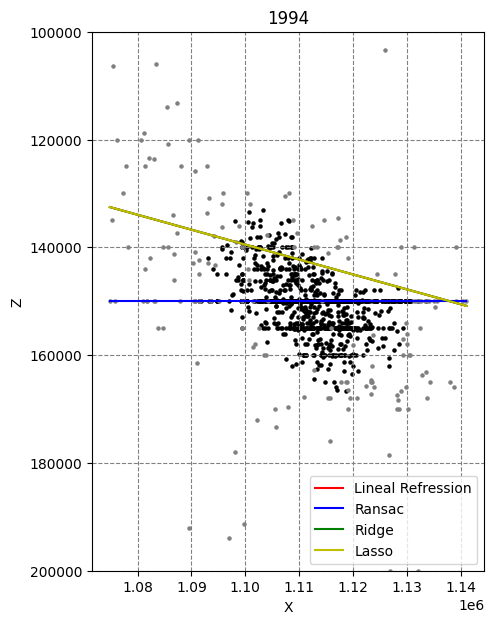

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


######## 
  1995
R2 RegLin 0.16463146518027572
R2 Ransac -0.0760845815230975
R2 Ridge 0.16463146518027572
R2 Lasso 0.16463146518027627


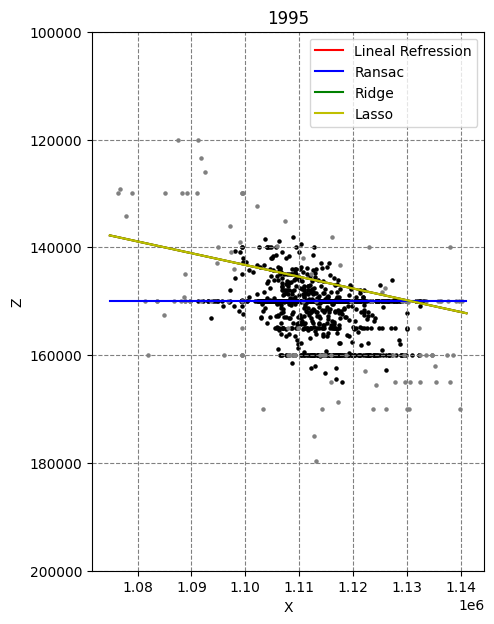

######## 
  1996
R2 RegLin 0.1891156401318883
R2 Ransac 0.028524204320205748
R2 Ridge 0.18911564013188897
R2 Lasso 0.18911564013188897


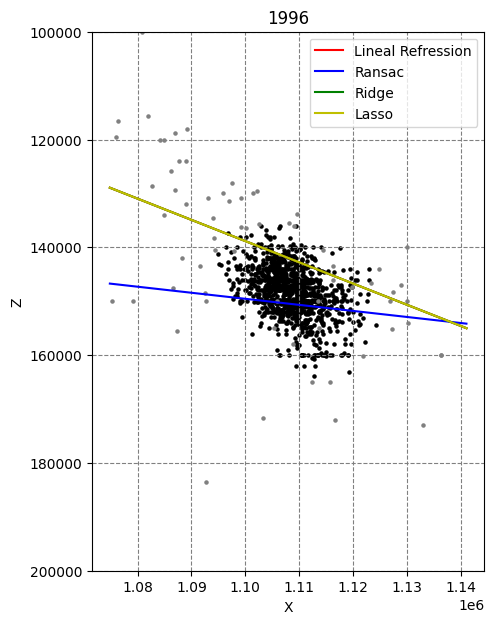

######## 
  1997
R2 RegLin 0.24451503700569788
R2 Ransac 0.049297107455095746
R2 Ridge 0.2445150370056992
R2 Lasso 0.24451503700569843


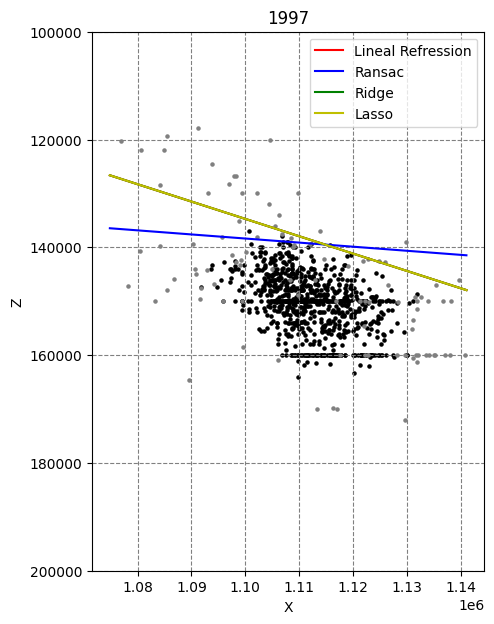

######## 
  1998
R2 RegLin 0.15401685921151287
R2 Ransac -0.03422960768657424
R2 Ridge 0.1540168592115133
R2 Lasso 0.15401685921151342


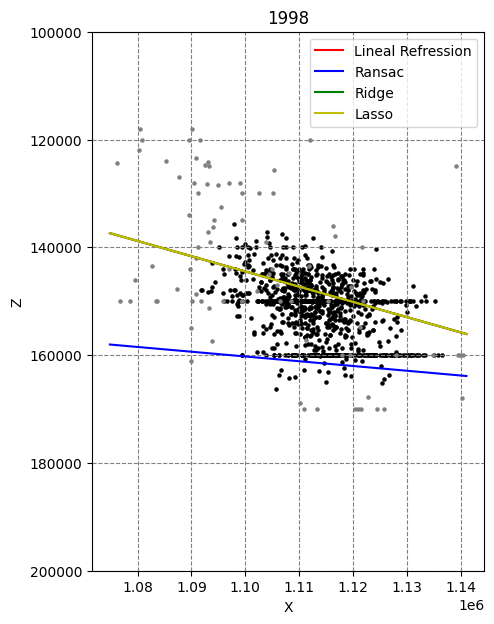

######## 
  1999
R2 RegLin 0.13278949603121637
R2 Ransac 0.09060547250138828
R2 Ridge 0.13278949603121704
R2 Lasso 0.13278949603121626


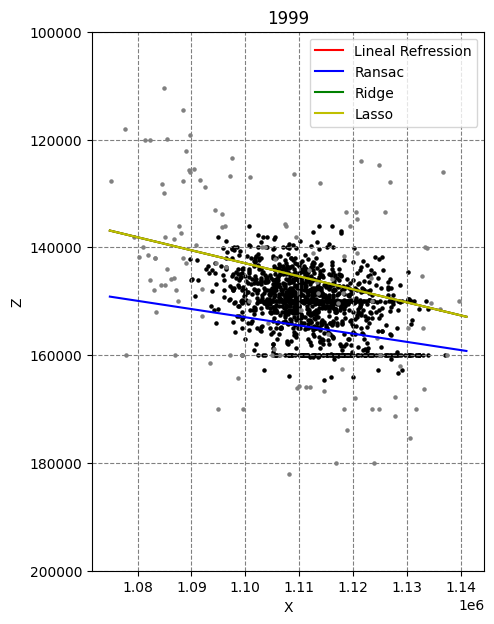

######## 
  2000
R2 RegLin 0.14640450049937015
R2 Ransac -0.3599843759765389
R2 Ridge 0.14640450049937093
R2 Lasso 0.14640450049937015


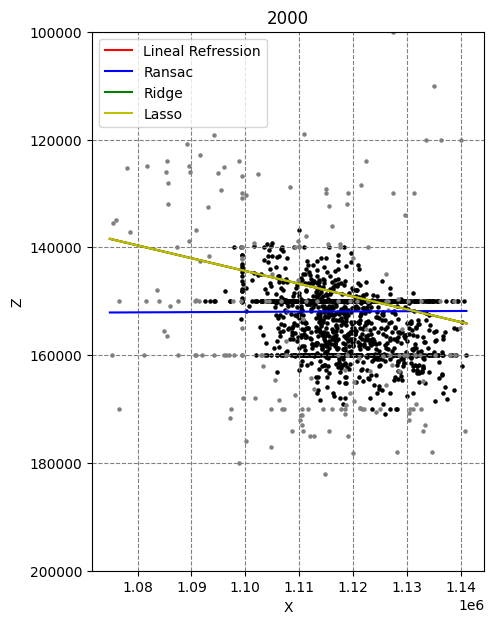

######## 
  2001
R2 RegLin 0.10221959947853965
R2 Ransac -0.09871782544138208
R2 Ridge 0.10221959947853965
R2 Lasso 0.10221959947853931


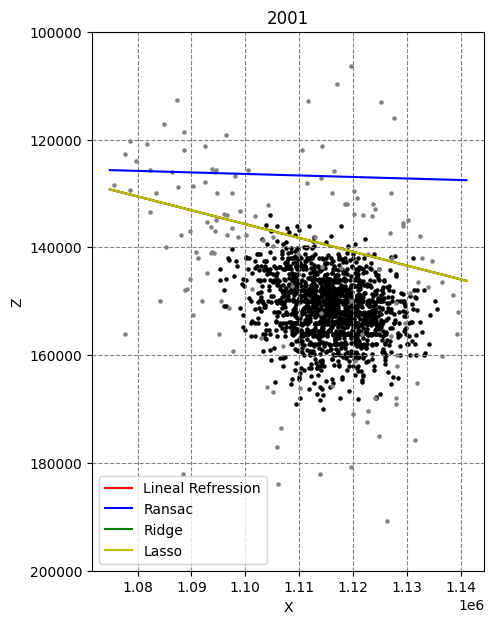

######## 
  2002
R2 RegLin 0.11779595590419145
R2 Ransac 0.051412052847659595
R2 Ridge 0.11779595590419167
R2 Lasso 0.11779595590419134


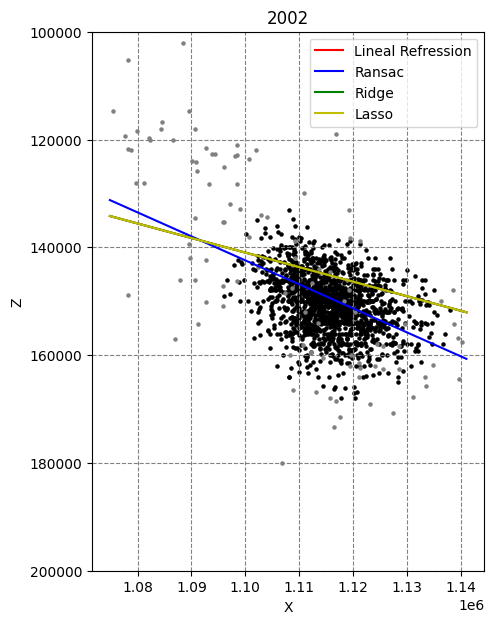

######## 
  2003
R2 RegLin 0.1623708138718989
R2 Ransac 0.09626050317356039
R2 Ridge 0.16237081387189867
R2 Lasso 0.16237081387189845


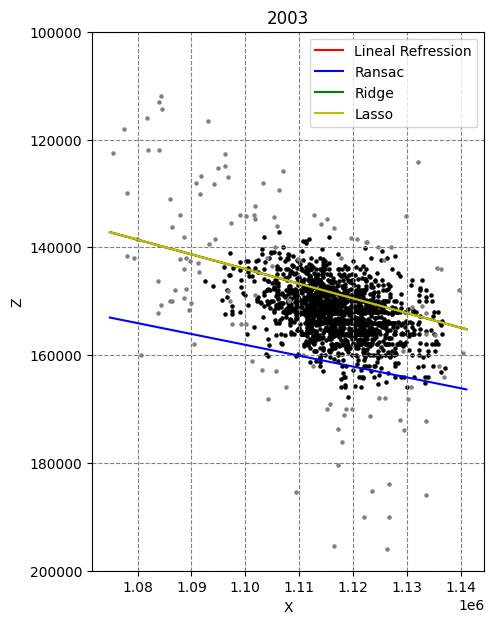

######## 
  2004
R2 RegLin 0.13624374184026677
R2 Ransac 0.050910568770790365
R2 Ridge 0.13624374184026655
R2 Lasso 0.13624374184026666


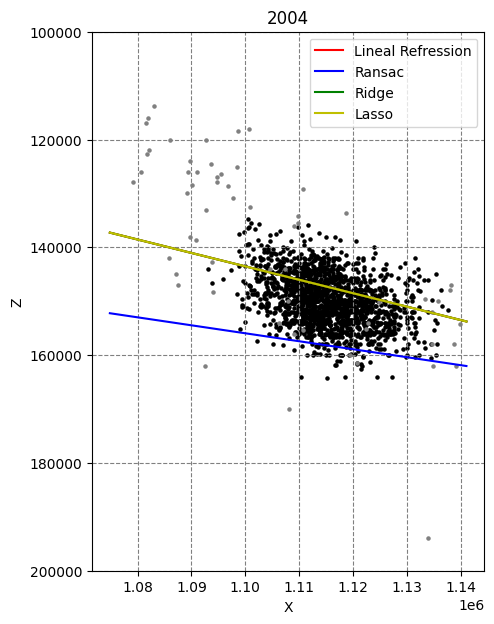

######## 
  2005
R2 RegLin 0.1492295782098182
R2 Ransac 0.10173682583948807
R2 Ridge 0.14922957820981897
R2 Lasso 0.1492295782098182


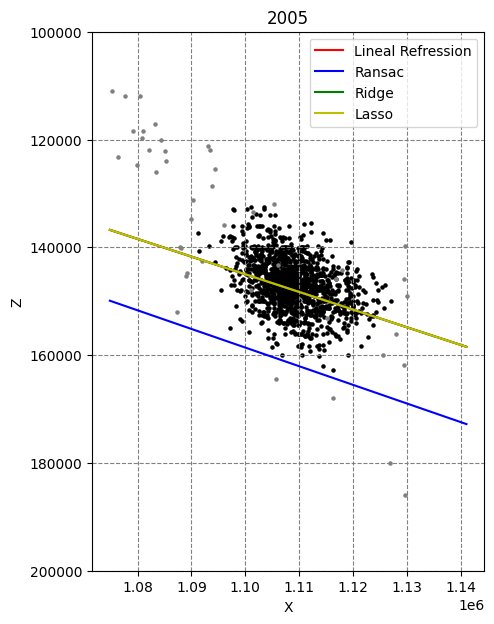

######## 
  2006
R2 RegLin 0.31180411294895427
R2 Ransac 0.16923162348422638
R2 Ridge 0.31180411294895427
R2 Lasso 0.31180411294895405


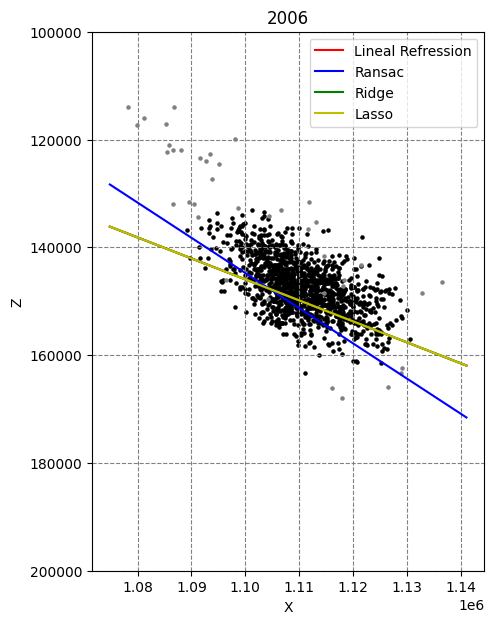

######## 
  2007
R2 RegLin 0.3395399214362399
R2 Ransac 0.1392746639702176
R2 Ridge 0.3395399214362399
R2 Lasso 0.3395399214362399


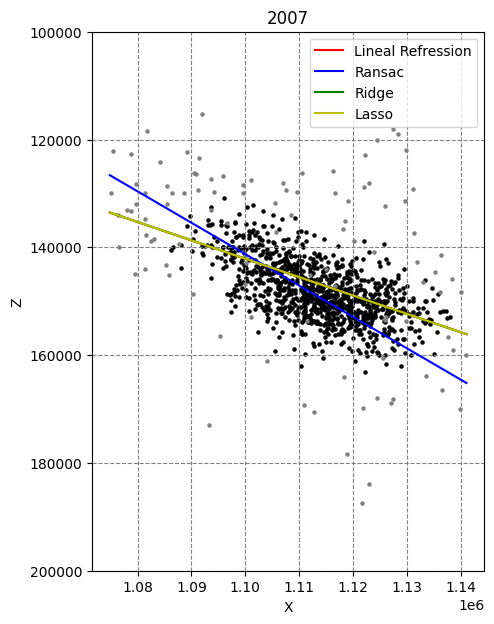

######## 
  2008
R2 RegLin 0.14675738678257755
R2 Ransac 0.09825502706005318
R2 Ridge 0.14675738678257777
R2 Lasso 0.14675738678257777


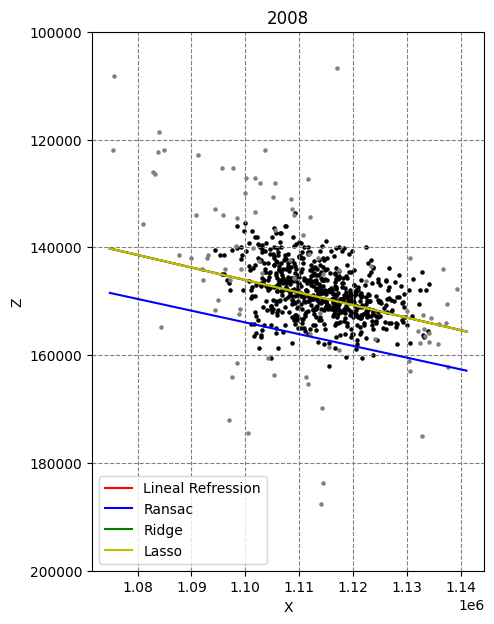

######## 
  2009
R2 RegLin 0.0748089960291769
R2 Ransac -0.21276564808958787
R2 Ridge 0.07480899602917668
R2 Lasso 0.0748089960291769


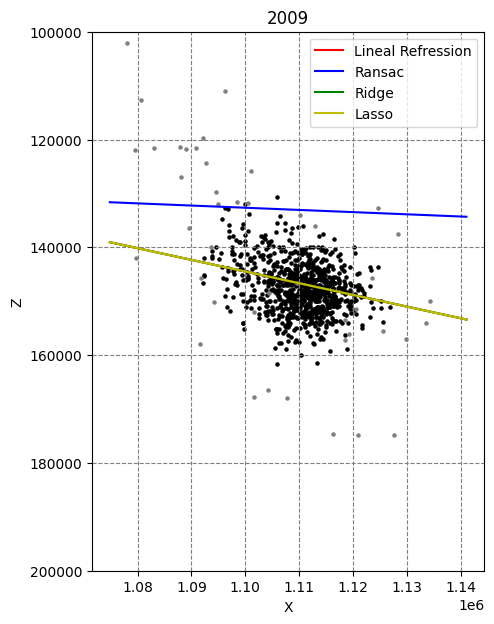

######## 
  2010
R2 RegLin 0.04424109565618417
R2 Ransac -0.14238957646308403
R2 Ridge 0.04424109565618428
R2 Lasso 0.04424109565618428


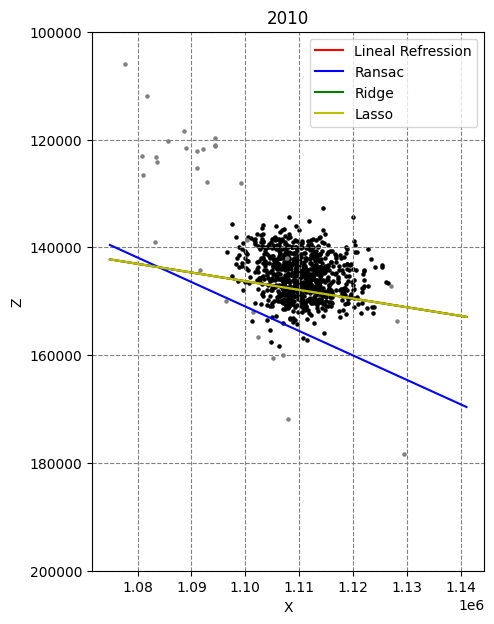

######## 
  2011
R2 RegLin 0.1515590634773848
R2 Ransac -0.022446752702687034
R2 Ridge 0.15155906347738446
R2 Lasso 0.15155906347738424


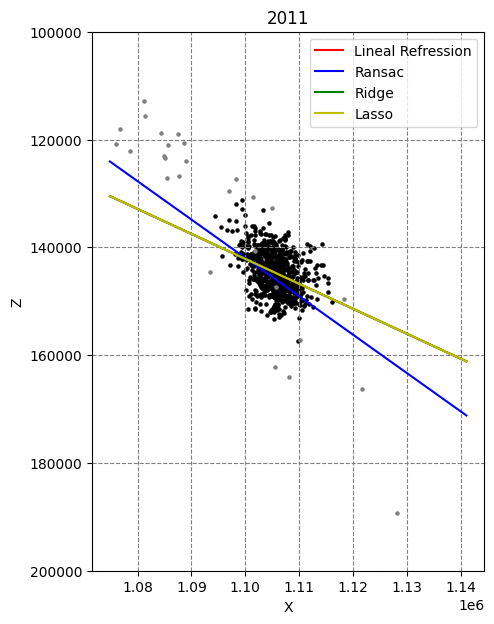

######## 
  2012
R2 RegLin 0.10779259675672415
R2 Ransac -0.03230307802986476
R2 Ridge 0.10779259675672481
R2 Lasso 0.1077925967567237


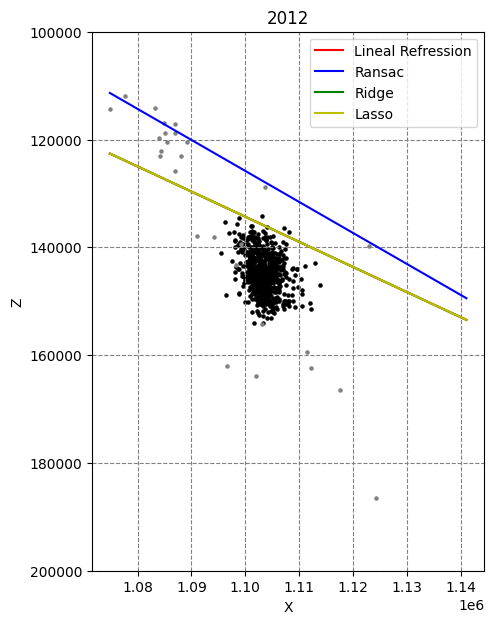

######## 
  2013
R2 RegLin 0.10509565850175673
R2 Ransac -0.11709705477379462
R2 Ridge 0.1050956585017585
R2 Lasso 0.1050956585017565


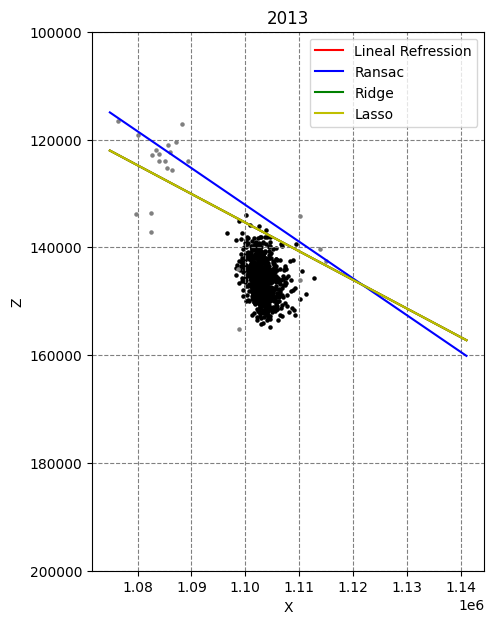

######## 
  2014
R2 RegLin 0.12255080924306117
R2 Ransac 0.10671313870977062
R2 Ridge 0.12255080924306183
R2 Lasso 0.12255080924306083


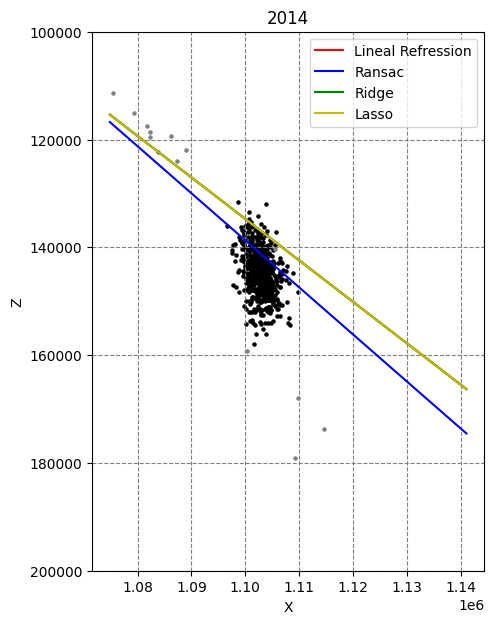

######## 
  2015
R2 RegLin 0.17064667256190247
R2 Ransac -0.1622332243250646
R2 Ridge 0.17064667256190325
R2 Lasso 0.17064667256190325


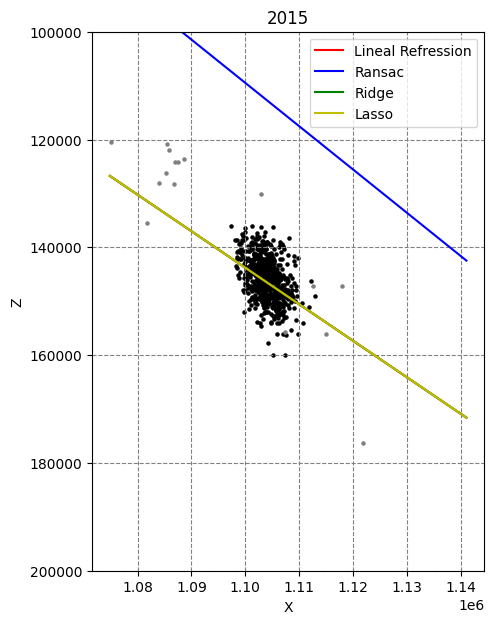

######## 
  2016
R2 RegLin 0.1665034212300588
R2 Ransac 0.06354943642566058
R2 Ridge 0.1665034212300609
R2 Lasso 0.166503421230059


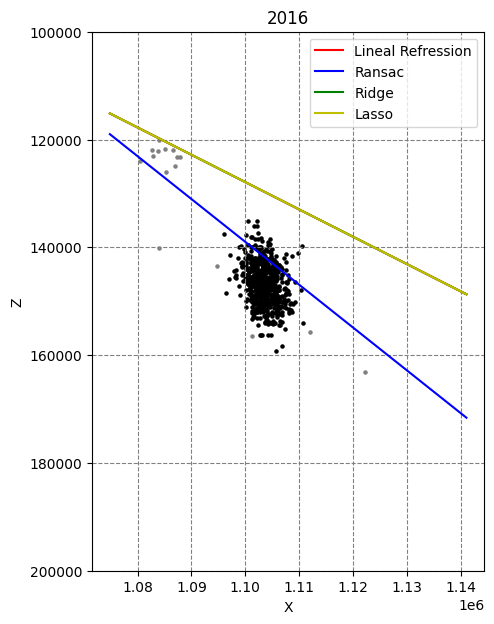

######## 
  2017
R2 RegLin 0.197150552299439
R2 Ransac 0.009090637544955427
R2 Ridge 0.1971505522994359
R2 Lasso 0.19715055229944045


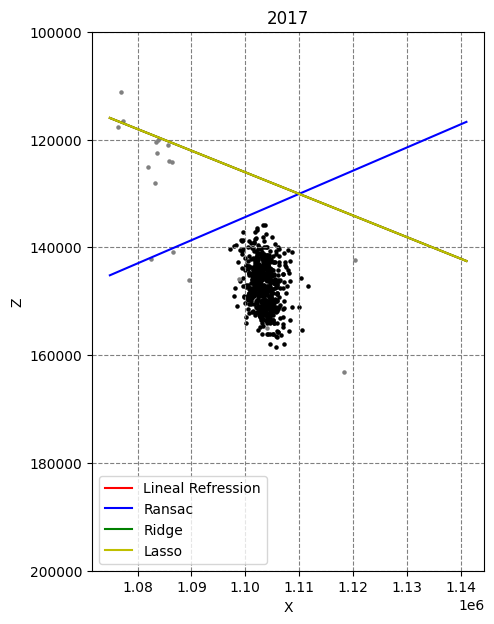

######## 
  2018
R2 RegLin 0.11332857500377547
R2 Ransac -0.06607440600800518
R2 Ridge 0.11332857500377536
R2 Lasso 0.1133285750037758


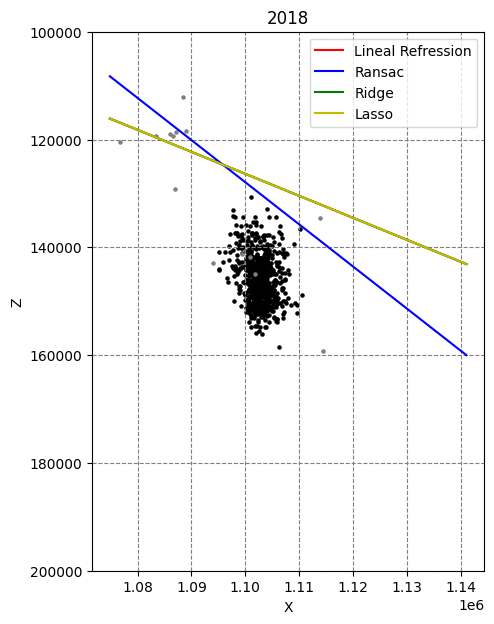

######## 
  2019
R2 RegLin 0.12716291716827244
R2 Ransac 0.05665450408209316
R2 Ridge 0.12716291716827222
R2 Lasso 0.1271629171682721


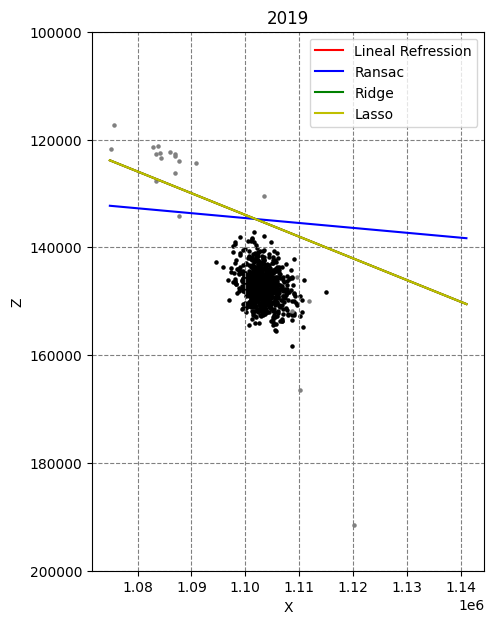

######## 
  2020
R2 RegLin 0.21866256965456088
R2 Ransac 0.08008426087199072
R2 Ridge 0.21866256965455988
R2 Lasso 0.21866256965456132


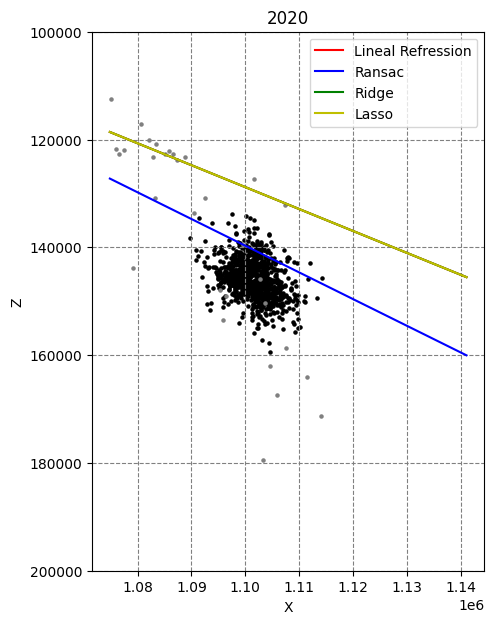

######## 
  2021
R2 RegLin 0.21148069736521424
R2 Ransac 0.16707074622079376
R2 Ridge 0.21148069736521424
R2 Lasso 0.21148069736521524


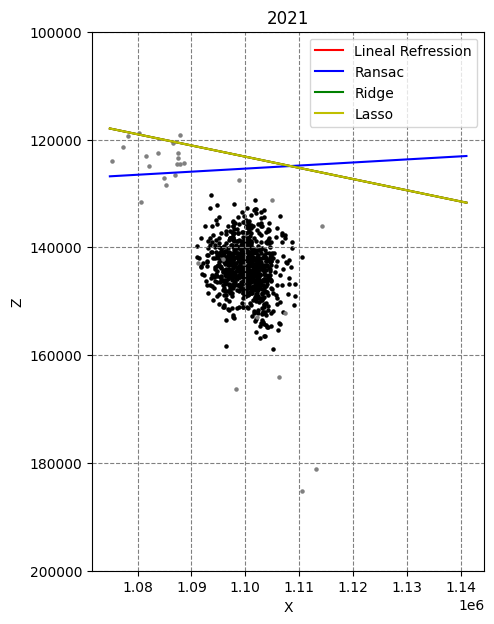

######## 
  2022
R2 RegLin 0.16231201218528446
R2 Ransac 0.08893693066787656
R2 Ridge 0.16231201218528446
R2 Lasso 0.16231201218528302


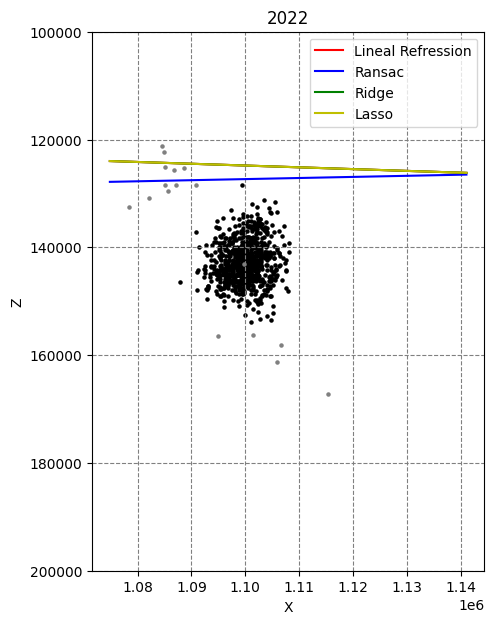

######## 
  2023
R2 RegLin 0.13603852071132616
R2 Ransac -0.22377685764703936
R2 Ridge 0.13603852071132427
R2 Lasso 0.13603852071132339


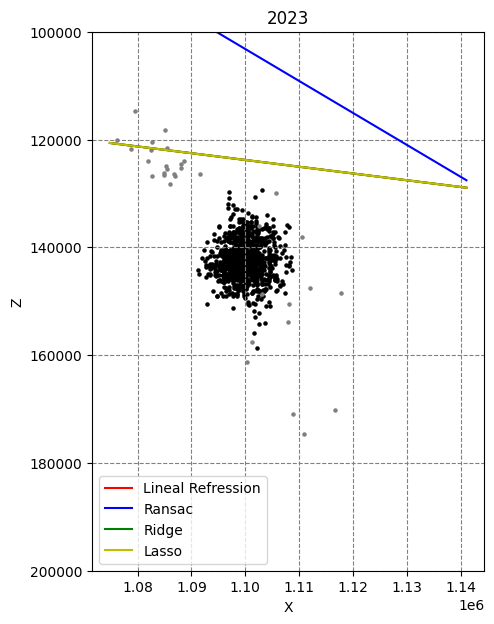

In [ ]:
years = np.arange(1994, 2024,1)
diccModeloLineal = {'year':[],
                    'wX':[],
                    'wY':[],
                    'R2':[],
                    'RMSE':[],
                    'b':[]}

puntosPred = np.array([[gdf['X'].min(), gdf['Y'].min()],
                        [gdf['X'].max(), gdf['Y'].min()]])

for year in years:
  gdf2 = gdf[gdf['Date-Time'].dt.year == year].copy()
  clustering = DBSCAN(eps=5000, min_samples=15).fit(gdf2[['X', 'Y', 'Z']].to_numpy())

  filtroDBSCAM = clustering.labels_ == 0
  outLiers = clustering.labels_ == -1

  gdf3 = gdf2[filtroDBSCAM].copy()
  X = gdf3[['X', 'Y']].to_numpy()
  y = gdf3['Z'].to_numpy().reshape(-1, 1)

  # Fit line using all data
  model = linear_model.LinearRegression()
  model.fit(X, y)
  diccModeloLineal['year'].append(year)
  diccModeloLineal['wX'].append(model.coef_[0][0])
  diccModeloLineal['wY'].append(model.coef_[0][1])
  diccModeloLineal['b'].append(model.intercept_[0])

  # Robustly fit linear model with RANSAC algorithm
  model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression())
  model_ransac.fit(X, y)
  inlier_mask = model_ransac.inlier_mask_
  outlier_mask = np.logical_not(inlier_mask)

  # Ridge linear regrtesion l2
  modelRidge = linear_model.Ridge(alpha=0.1)
  modelRidge.fit(X, y)

  # Lasso linear regrtesion L1
  modelLasso = linear_model.Lasso(alpha=0.1)
  modelLasso.fit(X, y)

  # Predict data of estimated models
  line_y = model.predict(puntosPred)
  line_y_ransac = model_ransac.predict(puntosPred)
  line_y_ridge = modelRidge.predict(puntosPred)
  line_y_lasso = modelLasso.predict(puntosPred)
  print('######## \n ', year)
  print('R2 RegLin', r2_score(y, model.predict(X)))
  print('R2 Ransac', r2_score(y, model_ransac.predict(X)))
  print('R2 Ridge', r2_score(y, modelRidge.predict(X)))
  print('R2 Lasso', r2_score(y, modelLasso.predict(X)))

  # Errores
  diccModeloLineal['R2'].append(r2_score(y, model.predict(X)))
  diccModeloLineal['RMSE'].append(np.sqrt(mean_squared_error(y, model.predict(X))))


  # Plot
  fig, ax = plt.subplots(1,1,figsize=(7,7))
  ax.scatter(gdf2['X'][filtroDBSCAM], gdf2['Z'][filtroDBSCAM], c='k', s=5)
  ax.scatter(gdf2['X'][outLiers], gdf2['Z'][outLiers], c='grey', s=5)

  ax.plot(puntosPred[:,0], line_y, color='r', label='Lineal Refression')
  ax.plot(puntosPred[:,0], line_y_ransac, color='b', label='Ransac')
  ax.plot(puntosPred[:,0], line_y_ridge, color='g', label='Ridge')
  ax.plot(puntosPred[:,0], line_y_lasso, color='y', label='Lasso')

  ax.legend()
  ax.grid(ls='--', c='grey')
  ax.invert_yaxis()
  ax.set_ylim(200000, 100000)
  ax.set_aspect('equal')
  ax.set_xlabel('X')
  ax.set_ylabel('Z')
  plt.title(year)
  plt.show()


In [ ]:
df_ModeloLineal = pd.DataFrame(diccModeloLineal)
df_ModeloLineal

year        wX        wY        R2         RMSE             b
0   1994  0.276993  0.218548  0.260479  3996.652991 -4.297778e+05
1   1995  0.218290  0.142687  0.164631  3737.736103 -2.695867e+05
2   1996  0.393942  0.172217  0.189116  4148.731987 -5.029846e+05
3   1997  0.321980  0.334174  0.244515  4610.072152 -6.240116e+05
4   1998  0.282841  0.094121  0.154017  5197.730180 -2.805932e+05
5   1999  0.241638  0.127763  0.132789  4965.581362 -2.775114e+05
6   2000  0.237241  0.146060  0.146405  5302.361901 -2.934025e+05
7   2001  0.256484  0.327591  0.102220  5485.281990 -5.430309e+05
8   2002  0.270013  0.151216  0.117796  5050.331778 -3.391057e+05
9   2003  0.272350  0.091958  0.162371  4522.442422 -2.668855e+05
10  2004  0.249219  0.071410  0.136244  4457.585283 -2.170577e+05
11  2005  0.327875 -0.027908  0.149230  4462.288587 -1.818743e+05
12  2006  0.389608 -0.073415  0.311804  4155.555843 -1.937381e+05
13  2007  0.341162  0.043604  0.339540  4476.954939 -2.859497e+05
14  2008  0.232743 -0.027457  0.146757  4432.120673 -7.670373e+04
15  2009  0.216841  0.022273  0.074809  4539.567814 -1.209937e+05
16  2010  0.161193 -0.080812  0.044241  3909.907258  6.680693e+04
17  2011  0.463349 -0.010146  0.151559  3584.740086 -3.552511e+05
18  2012  0.466497  0.272870  0.107793  3439.720621 -7.091669e+05
19  2013  0.531886  0.254636  0.105096  3364.938254 -7.579333e+05
20  2014  0.769744  0.229550  0.122551  3806.845143 -9.898909e+05
21  2015  0.677939 -0.013099  0.170647  3625.311024 -5.860842e+05
22  2016  0.507157  0.487862  0.166503  3417.009605 -1.020588e+06
23  2017  0.401175  0.553688  0.197151  3738.817427 -9.855246e+05
24  2018  0.408138  0.526381  0.113329  4267.959212 -9.598358e+05
25  2019  0.403183  0.339128  0.127163  2936.560993 -7.200685e+05
26  2020  0.407005  0.470603  0.218663  3208.298464 -8.885999e+05
27  2021  0.207999  0.623103  0.211481  3943.490585 -8.599657e+05
28  2022  0.033120  0.571011  0.162312  3543.048904 -6.028887e+05
29  2023  0.125503  0.581512  0.136039  3502.270725 -7.182572e+05

In [ ]:
v_y = np.array([0,1])#.reshape(2,1)

prodPunto = np.dot(df_ModeloLineal[['wX', 'wY']].to_numpy(), v_y)
prodNormas = np.linalg.norm(df_ModeloLineal[['wX', 'wY']].to_numpy(), axis=1) * np.linalg.norm(v_y)
rumboGrados = np.rad2deg(np.arccos(prodPunto/prodNormas))
#rumboGrados

In [ ]:
pesos = df_ModeloLineal.loc[0, ['wX', 'wY']].to_numpy()
print(pesos[0]*0 + pesos[1]*0)
print(pesos[0]*pesos[0] + pesos[1]*pesos[1])
print(np.linalg.norm(pesos))
print(np.arctan((pesos[0]*pesos[0] + pesos[1]*pesos[1]) / np.linalg.norm(pesos)))
print(np.rad2deg(np.arctan((pesos[0]*pesos[0] + pesos[1]*pesos[1]) / np.linalg.norm(pesos))))

0.0
0.1244883118215609
0.35282901215965917
0.3391928709866845
19.434319948462452


In [ ]:
pesos = df_ModeloLineal[['wX', 'wY']].to_numpy()
normaPesos = np.linalg.norm(pesos, axis=1)
z_pred = pesos[:,0]*pesos[:,0] + pesos[:,1]*pesos[:,1]
buzamientoGrados = np.rad2deg(np.arctan(z_pred/normaPesos))
#buzamientoGrados

In [ ]:
df_ModeloLineal['DipDir'] = np.round(rumboGrados,0).astype(int)
df_ModeloLineal['Dip'] = np.round(buzamientoGrados,0).astype(int)
df_ModeloLineal

year        wX        wY        R2         RMSE             b  DipDir  Dip
0   1994  0.276993  0.218548  0.260479  3996.652991 -4.297778e+05      52   19
1   1995  0.218290  0.142687  0.164631  3737.736103 -2.695867e+05      57   15
2   1996  0.393942  0.172217  0.189116  4148.731987 -5.029846e+05      66   23
3   1997  0.321980  0.334174  0.244515  4610.072152 -6.240116e+05      44   25
4   1998  0.282841  0.094121  0.154017  5197.730180 -2.805932e+05      72   17
5   1999  0.241638  0.127763  0.132789  4965.581362 -2.775114e+05      62   15
6   2000  0.237241  0.146060  0.146405  5302.361901 -2.934025e+05      58   16
7   2001  0.256484  0.327591  0.102220  5485.281990 -5.430309e+05      38   23
8   2002  0.270013  0.151216  0.117796  5050.331778 -3.391057e+05      61   17
9   2003  0.272350  0.091958  0.162371  4522.442422 -2.668855e+05      71   16
10  2004  0.249219  0.071410  0.136244  4457.585283 -2.170577e+05      74   15
11  2005  0.327875 -0.027908  0.149230  4462.288587 -1.818743e+05      95   18
12  2006  0.389608 -0.073415  0.311804  4155.555843 -1.937381e+05     101   22
13  2007  0.341162  0.043604  0.339540  4476.954939 -2.859497e+05      83   19
14  2008  0.232743 -0.027457  0.146757  4432.120673 -7.670373e+04      97   13
15  2009  0.216841  0.022273  0.074809  4539.567814 -1.209937e+05      84   12
16  2010  0.161193 -0.080812  0.044241  3909.907258  6.680693e+04     117   10
17  2011  0.463349 -0.010146  0.151559  3584.740086 -3.552511e+05      91   25
18  2012  0.466497  0.272870  0.107793  3439.720621 -7.091669e+05      60   28
19  2013  0.531886  0.254636  0.105096  3364.938254 -7.579333e+05      64   31
20  2014  0.769744  0.229550  0.122551  3806.845143 -9.898909e+05      73   39
21  2015  0.677939 -0.013099  0.170647  3625.311024 -5.860842e+05      91   34
22  2016  0.507157  0.487862  0.166503  3417.009605 -1.020588e+06      46   35
23  2017  0.401175  0.553688  0.197151  3738.817427 -9.855246e+05      36   34
24  2018  0.408138  0.526381  0.113329  4267.959212 -9.598358e+05      38   34
25  2019  0.403183  0.339128  0.127163  2936.560993 -7.200685e+05      50   28
26  2020  0.407005  0.470603  0.218663  3208.298464 -8.885999e+05      41   32
27  2021  0.207999  0.623103  0.211481  3943.490585 -8.599657e+05      18   33
28  2022  0.033120  0.571011  0.162312  3543.048904 -6.028887e+05       3   30
29  2023  0.125503  0.581512  0.136039  3502.270725 -7.182572e+05      12   31

In [ ]:
df_ModeloLineal.to_csv(pathDatos+'df_DirBuzPlanos_DBSCA.csv', index=False)

# RANSAC algorithm

######## 
  1994
R2 RegLin 0.21034386277972028
R2 Ransac 0.00043172092421617236
R2 Ridge 0.21034386277972084
R2 Lasso 0.2103438627797204


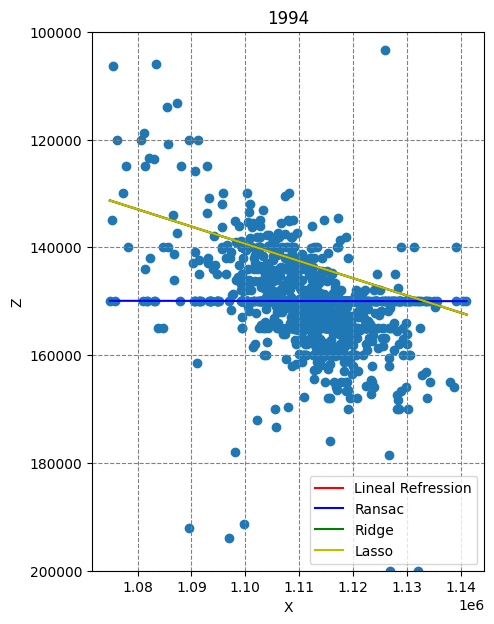

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


######## 
  1995
R2 RegLin 0.20754169461808236
R2 Ransac -0.04419882420177079
R2 Ridge 0.20754169461808214
R2 Lasso 0.20754169461808225


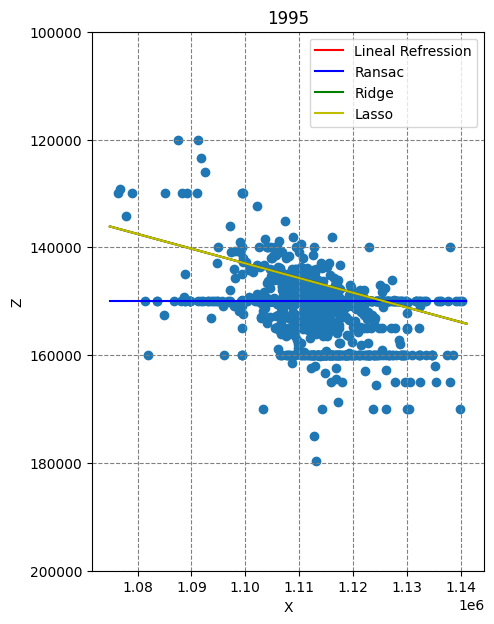

######## 
  1996
R2 RegLin 0.2552822864100168
R2 Ransac 0.19360817536885366
R2 Ridge 0.25528228641001605
R2 Lasso 0.2552822864100168


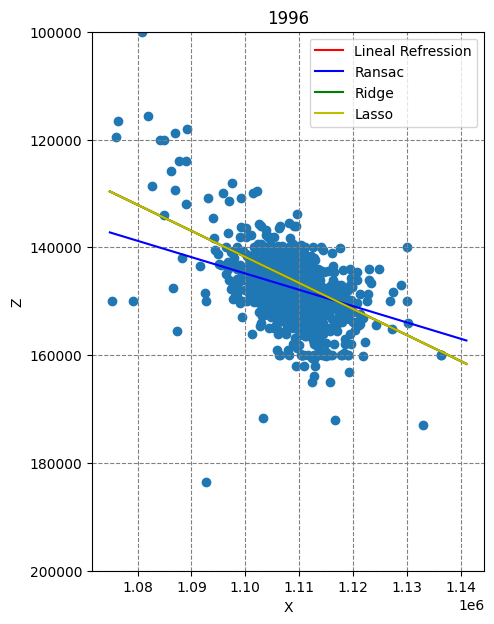

######## 
  1997
R2 RegLin 0.2490582343733071
R2 Ransac 0.02771202277007867
R2 Ridge 0.249058234373306
R2 Lasso 0.24905823437330699


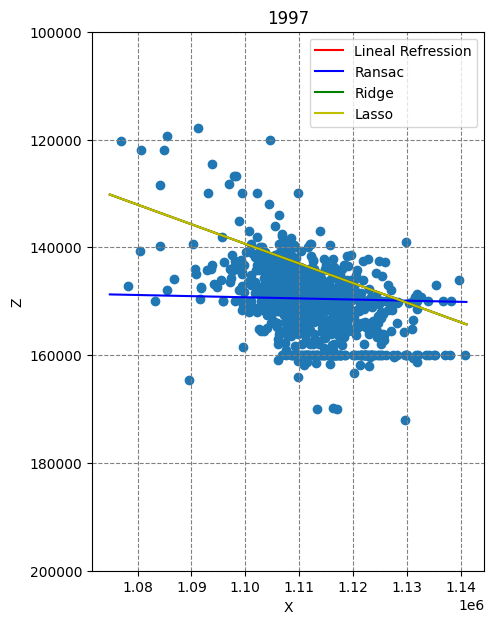

######## 
  1998
R2 RegLin 0.2380442172998105
R2 Ransac 0.020766650936098197
R2 Ridge 0.2380442172998104
R2 Lasso 0.23804421729981018


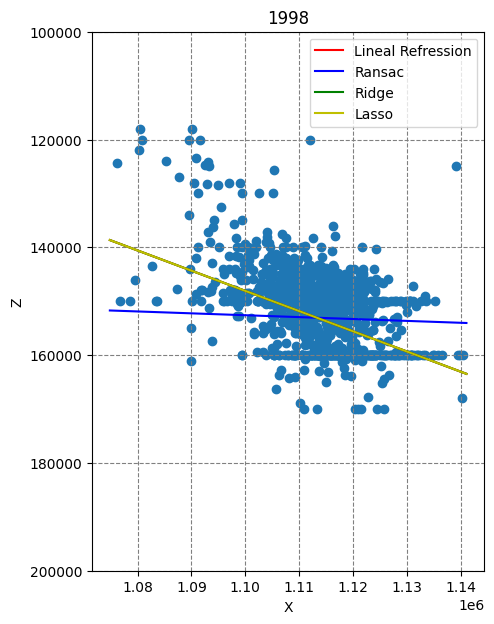

######## 
  1999
R2 RegLin 0.1593358364166152
R2 Ransac 0.03633268561346492
R2 Ridge 0.1593358364166153
R2 Lasso 0.1593358364166153


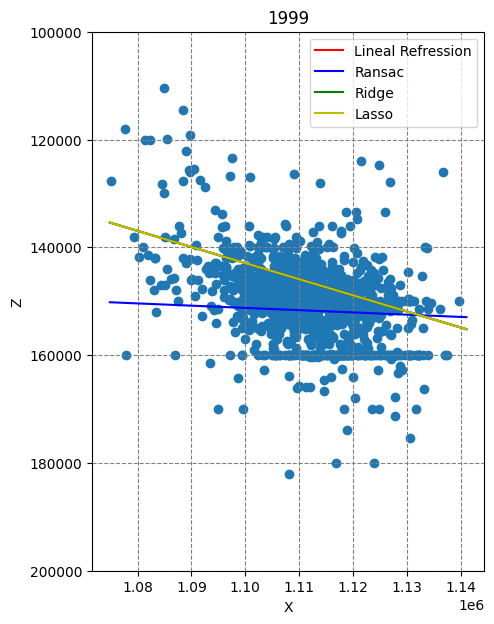

######## 
  2000
R2 RegLin 0.09484987788721533
R2 Ransac -0.109077449359825
R2 Ridge 0.09484987788721522
R2 Lasso 0.09484987788721533


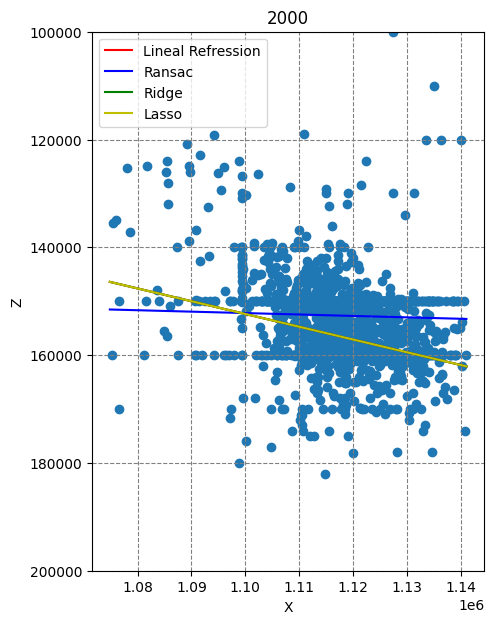

######## 
  2001
R2 RegLin 0.10474511124176877
R2 Ransac 0.034679959052782316
R2 Ridge 0.1047451112417691
R2 Lasso 0.10474511124176877


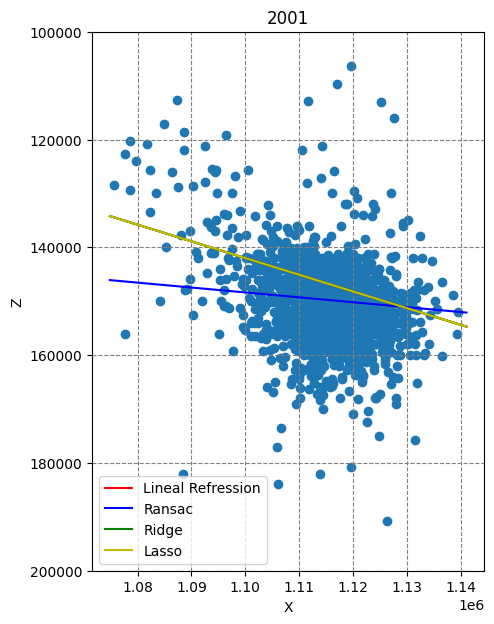

######## 
  2002
R2 RegLin 0.25270283857651843
R2 Ransac 0.17078383037547873
R2 Ridge 0.2527028385765183
R2 Lasso 0.2527028385765181


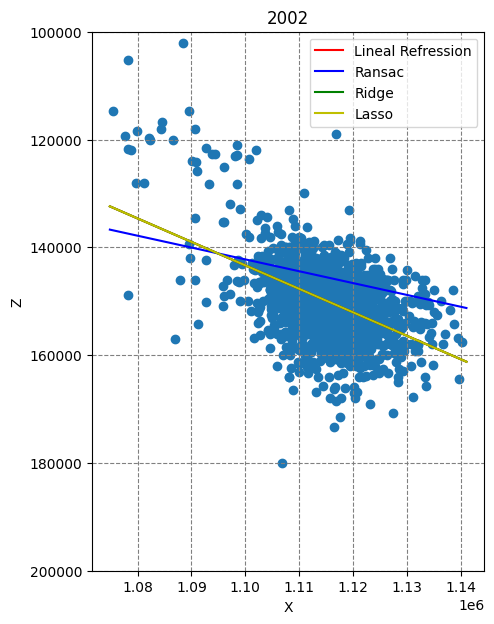

######## 
  2003
R2 RegLin 0.21622221686477994
R2 Ransac 0.1693804674312821
R2 Ridge 0.21622221686477983
R2 Lasso 0.21622221686477983


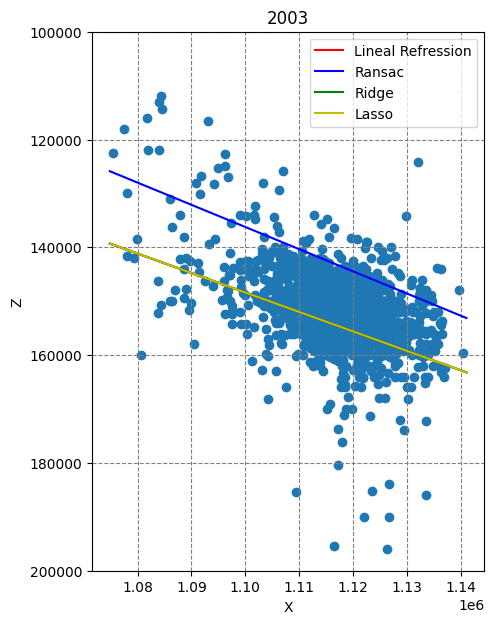

######## 
  2004
R2 RegLin 0.23184557840488695
R2 Ransac 0.18636780233115968
R2 Ridge 0.23184557840488718
R2 Lasso 0.23184557840488706


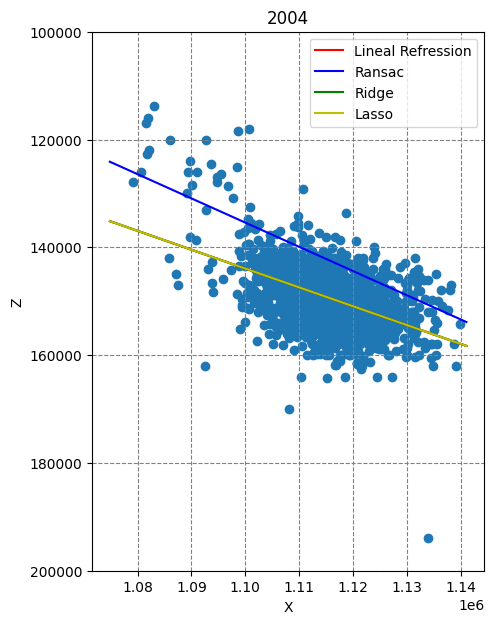

######## 
  2005
R2 RegLin 0.2950262648637728
R2 Ransac 0.26271651988006073
R2 Ridge 0.29502626486377304
R2 Lasso 0.29502626486377337


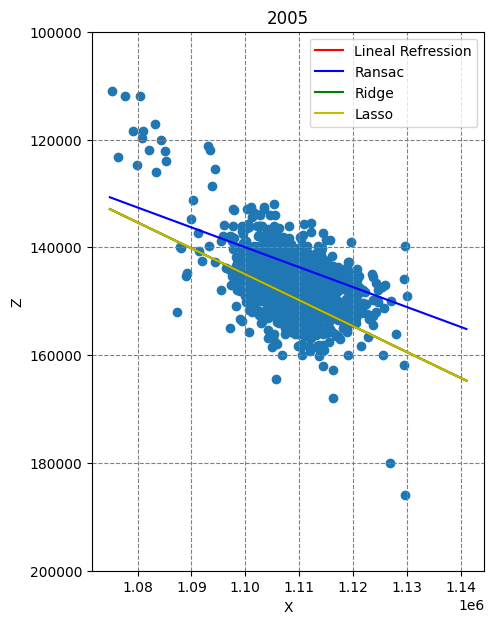

######## 
  2006
R2 RegLin 0.3869580684973851
R2 Ransac 0.3050798211647633
R2 Ridge 0.3869580684973851
R2 Lasso 0.38695806849738523


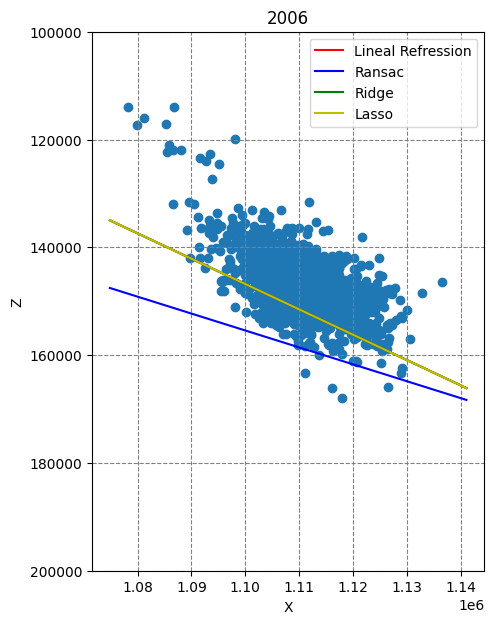

######## 
  2007
R2 RegLin 0.2840393724851016
R2 Ransac 0.2668549185612832
R2 Ridge 0.28403937248510147
R2 Lasso 0.28403937248510147


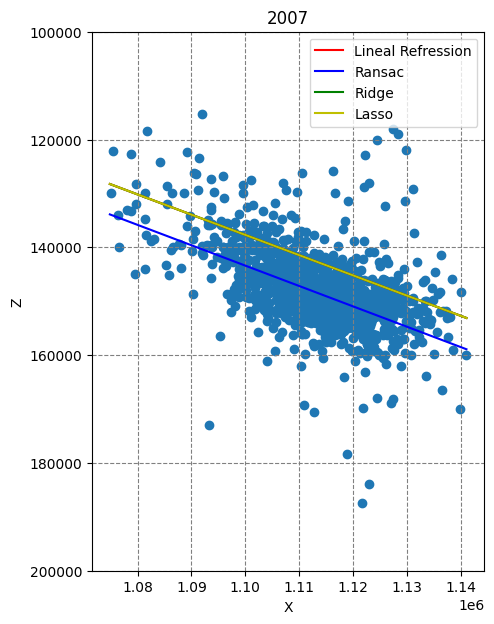

######## 
  2008
R2 RegLin 0.22040826996828022
R2 Ransac -0.009276348150143887
R2 Ridge 0.22040826996828
R2 Lasso 0.2204082699682801


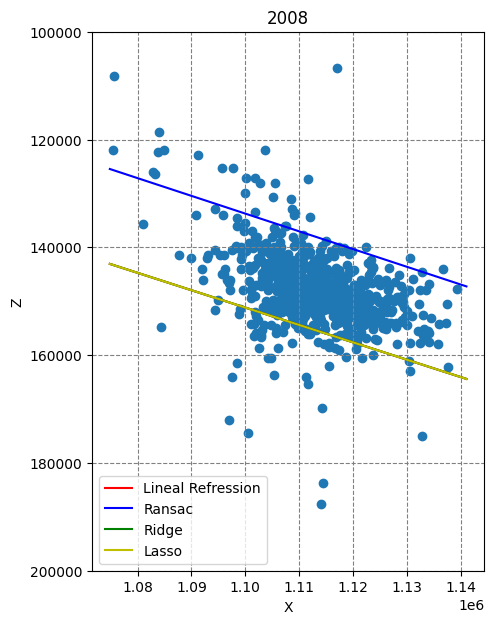

######## 
  2009
R2 RegLin 0.17506122559077641
R2 Ransac 0.10821581234748001
R2 Ridge 0.17506122559077608
R2 Lasso 0.17506122559077675


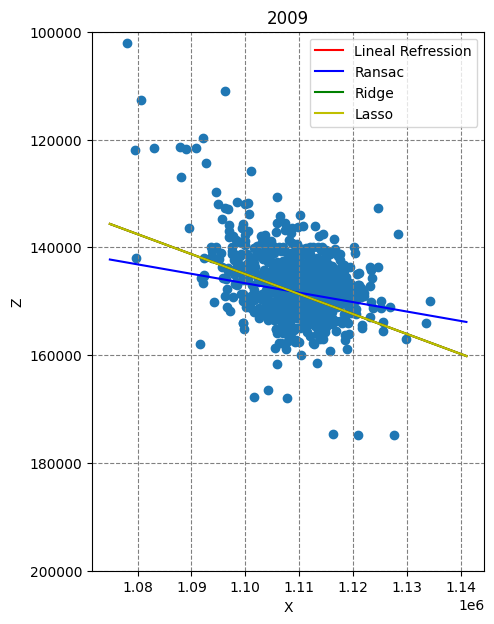

######## 
  2010
R2 RegLin 0.21775170874964034
R2 Ransac 0.07250026866115811
R2 Ridge 0.21775170874964067
R2 Lasso 0.21775170874964034


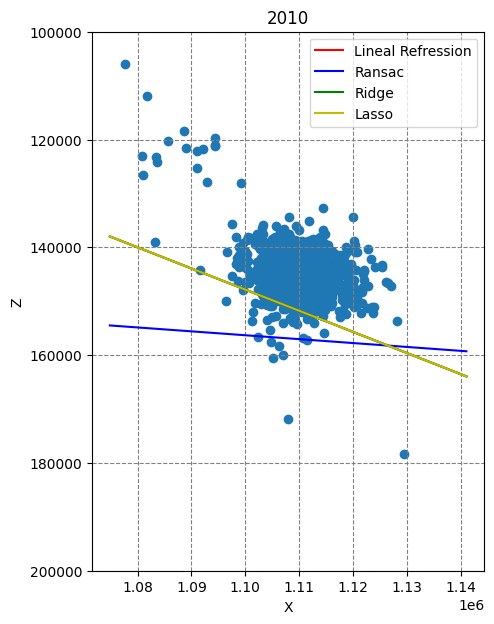

######## 
  2011
R2 RegLin 0.45136245469575165
R2 Ransac 0.3431398193367323
R2 Ridge 0.451362454695752
R2 Lasso 0.45136245469575154


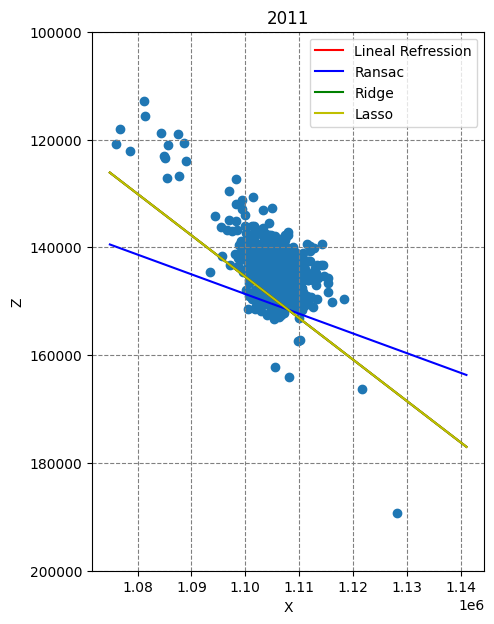

######## 
  2012
R2 RegLin 0.4211422922341024
R2 Ransac 0.26898939413365486
R2 Ridge 0.42114229223410227
R2 Lasso 0.42114229223410393


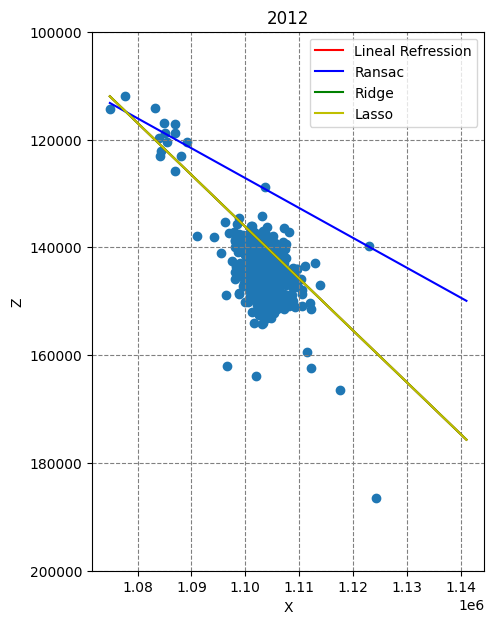

######## 
  2013
R2 RegLin 0.3746900756558763
R2 Ransac 0.06808728266166797
R2 Ridge 0.3746900756558761
R2 Lasso 0.3746900756558763


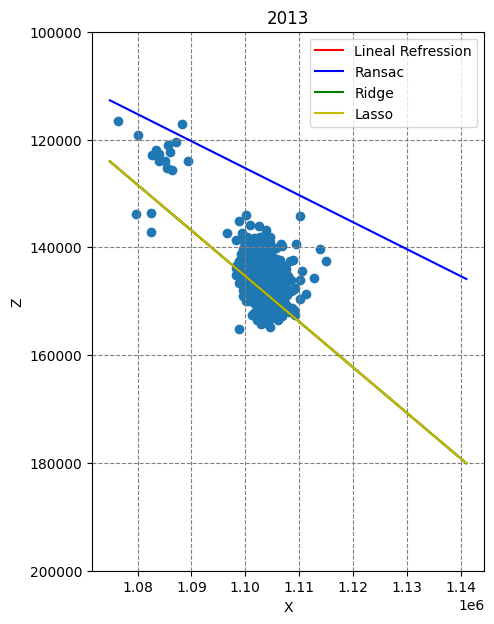

######## 
  2014
R2 RegLin 0.4041774510000603
R2 Ransac 0.3161303826254297
R2 Ridge 0.40417745100006064
R2 Lasso 0.40417745100006397


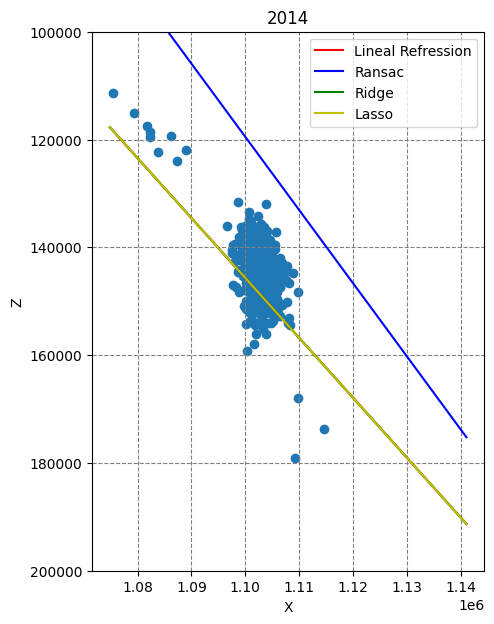

######## 
  2015
R2 RegLin 0.42808518301312537
R2 Ransac 0.08165795385562125
R2 Ridge 0.4280851830131246
R2 Lasso 0.4280851830131265


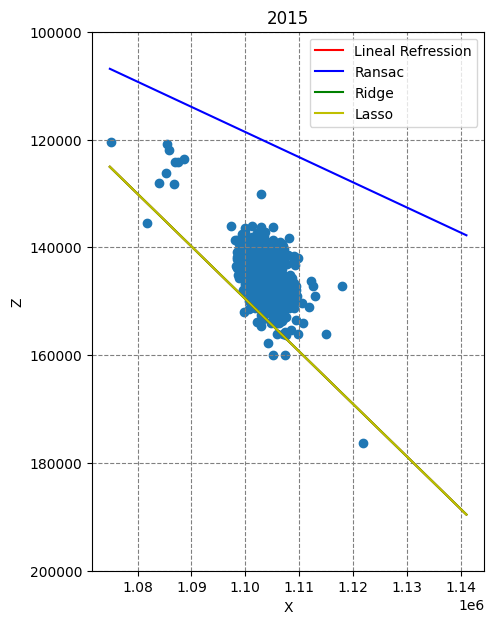

######## 
  2016
R2 RegLin 0.3975492000179084
R2 Ransac 0.28791414782394464
R2 Ridge 0.3975492000179073
R2 Lasso 0.3975492000179084


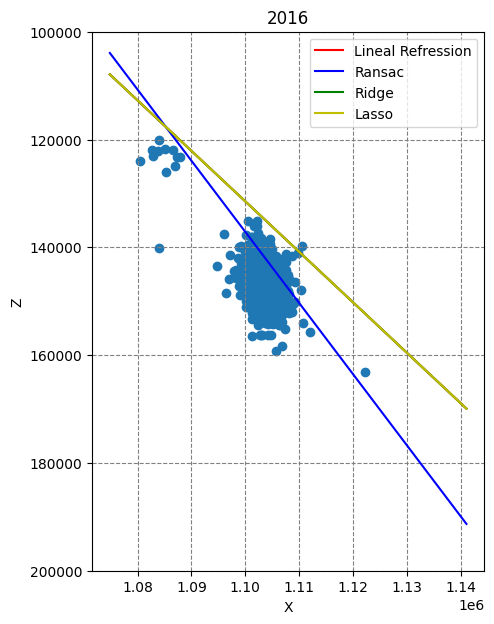

######## 
  2017
R2 RegLin 0.40005279976648056
R2 Ransac 0.2731473976292832
R2 Ridge 0.40005279976648056
R2 Lasso 0.4000527997664801


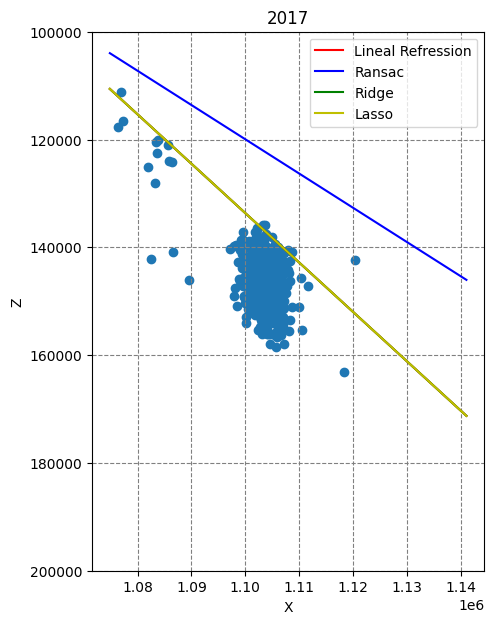

######## 
  2018
R2 RegLin 0.22876807485284856
R2 Ransac 0.07505384867811504
R2 Ridge 0.22876807485284878
R2 Lasso 0.22876807485284845


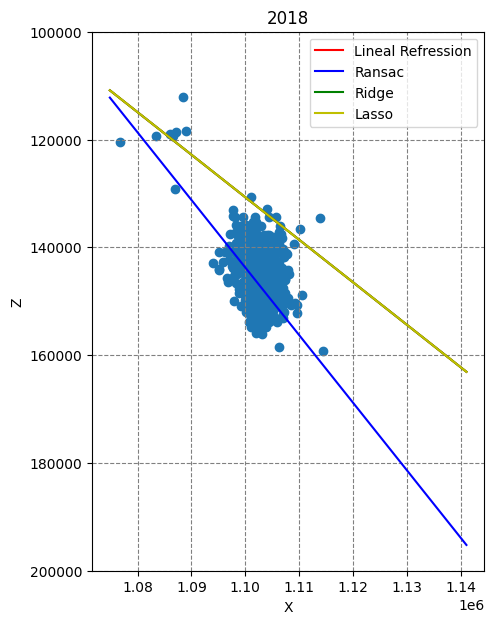

######## 
  2019
R2 RegLin 0.429504376499812
R2 Ransac 0.1055165866052965
R2 Ridge 0.429504376499812
R2 Lasso 0.42950437649981155


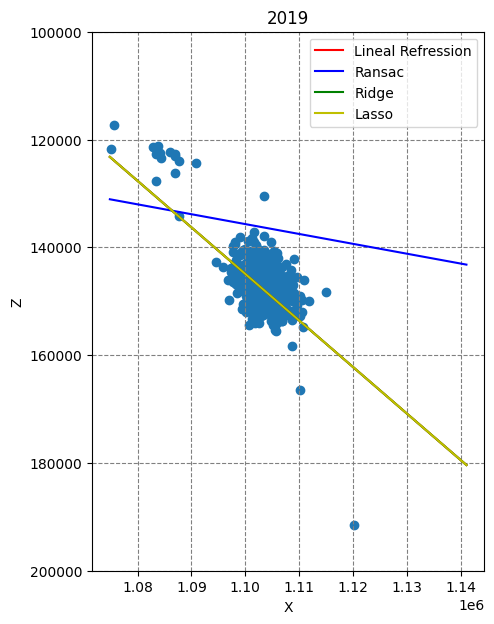

######## 
  2020
R2 RegLin 0.3045138645783566
R2 Ransac 0.19461612096663283
R2 Ridge 0.3045138645783575
R2 Lasso 0.30451386457835683


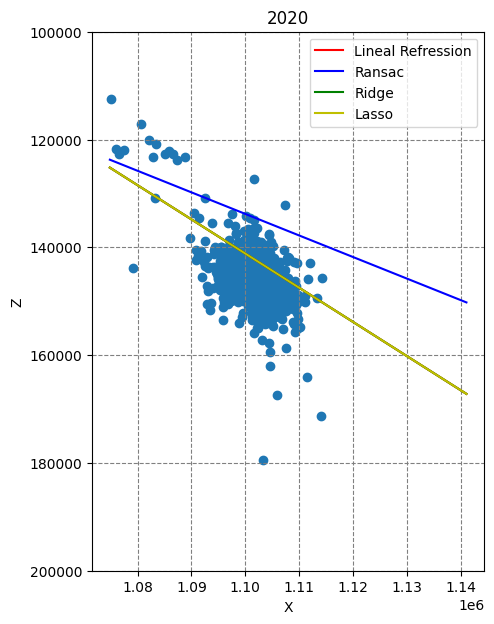

######## 
  2021
R2 RegLin 0.23306942544598042
R2 Ransac -0.08916033313763116
R2 Ridge 0.23306942544597886
R2 Lasso 0.23306942544597942


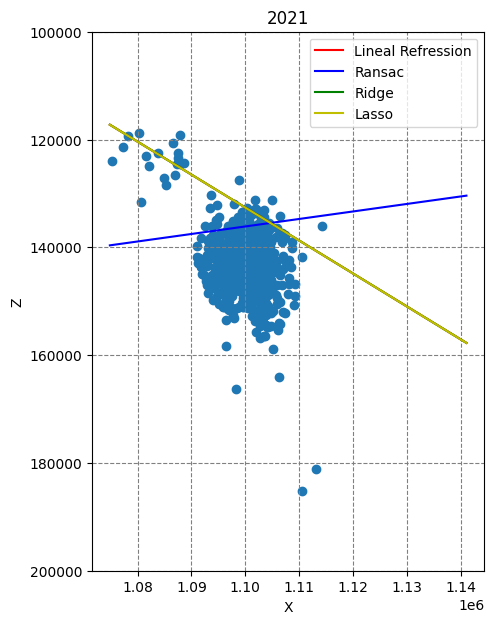

######## 
  2022
R2 RegLin 0.06745068064669124
R2 Ransac 0.0026550439625029343
R2 Ridge 0.06745068064669224
R2 Lasso 0.06745068064669169


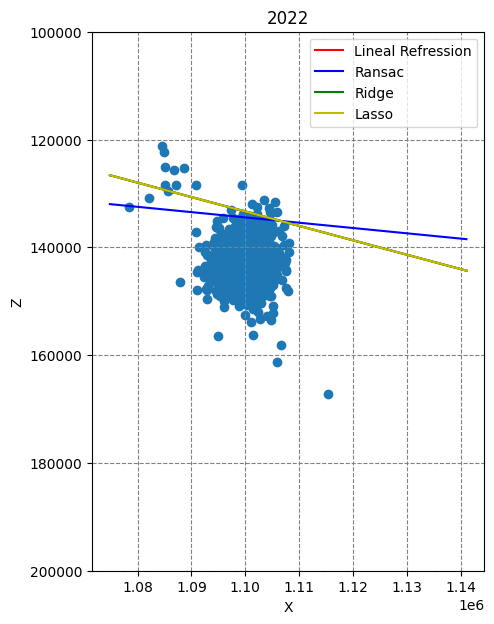

######## 
  2023
R2 RegLin 0.14406819245982339
R2 Ransac -0.08371534700138628
R2 Ridge 0.14406819245982339
R2 Lasso 0.14406819245982272


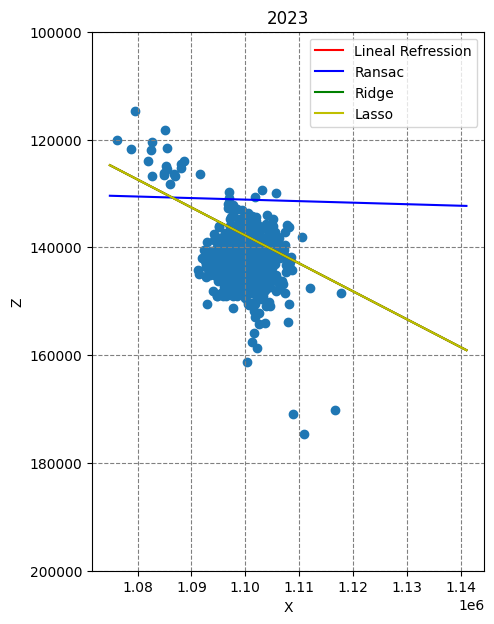

In [ ]:
# No resultó tan bueno el Ransac ... se toma la Lineal regresion normal

years = np.arange(1994, 2024,1)
diccModeloLineal = {'year':[],
                    'wX':[],
                    'wY':[],
                    'R2':[],
                    'RMSE':[],
                    'b':[]}




puntosPred = np.array([[gdf['X'].min(), gdf['Y'].min()],
                        [gdf['X'].max(), gdf['Y'].min()]])

for year in years:
  gdf2 = gdf[gdf['Date-Time'].dt.year == year].copy()
  X = gdf2[['X', 'Y']].to_numpy()
  y = gdf2['Z'].to_numpy().reshape(-1, 1)



  # Fit line using all data
  model = linear_model.LinearRegression()
  model.fit(X, y)
  diccModeloLineal['year'].append(year)
  diccModeloLineal['wX'].append(model.coef_[0][0])
  diccModeloLineal['wY'].append(model.coef_[0][1])
  diccModeloLineal['b'].append(model.intercept_[0])

  # Robustly fit linear model with RANSAC algorithm
  model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression())
  model_ransac.fit(X, y)
  inlier_mask = model_ransac.inlier_mask_
  outlier_mask = np.logical_not(inlier_mask)

  # Ridge linear regrtesion l2
  modelRidge = linear_model.Ridge(alpha=0.1)
  modelRidge.fit(X, y)

  # Lasso linear regrtesion L1
  modelLasso = linear_model.Lasso(alpha=0.1)
  modelLasso.fit(X, y)

  # Predict data of estimated models
  line_y = model.predict(puntosPred)
  line_y_ransac = model_ransac.predict(puntosPred)
  line_y_ridge = modelRidge.predict(puntosPred)
  line_y_lasso = modelLasso.predict(puntosPred)
  print('######## \n ', year)
  print('R2 RegLin', r2_score(y, model.predict(X)))
  print('R2 Ransac', r2_score(y, model_ransac.predict(X)))
  print('R2 Ridge', r2_score(y, modelRidge.predict(X)))
  print('R2 Lasso', r2_score(y, modelLasso.predict(X)))

  # Errores
  diccModeloLineal['R2'].append(r2_score(y, model.predict(X)))
  diccModeloLineal['RMSE'].append(np.sqrt(mean_squared_error(y, model.predict(X))))


  # Plot
  fig, ax = plt.subplots(1,1,figsize=(7,7))
  ax.scatter(X[:, 0], y)
  ax.plot(puntosPred[:,0], line_y, color='r', label='Lineal Refression')
  ax.plot(puntosPred[:,0], line_y_ransac, color='b', label='Ransac')
  ax.plot(puntosPred[:,0], line_y_ridge, color='g', label='Ridge')
  ax.plot(puntosPred[:,0], line_y_lasso, color='y', label='Lasso')

  ax.legend()
  ax.grid(ls='--', c='grey')
  ax.invert_yaxis()
  ax.set_ylim(200000, 100000)
  ax.set_aspect('equal')
  ax.set_xlabel('X')
  ax.set_ylabel('Z')
  plt.title(year)
  plt.show()


In [ ]:
df_ModeloLineal = pd.DataFrame(diccModeloLineal)
df_ModeloLineal

year        wX        wY        R2         RMSE             b
0   1994  0.319861  0.211458  0.210344  6746.301443 -4.685003e+05
1   1995  0.272646  0.134005  0.207542  4786.448546 -3.191636e+05
2   1996  0.483591  0.061069  0.255282  5217.822824 -4.640996e+05
3   1997  0.364019  0.176237  0.249058  5731.078152 -4.744186e+05
4   1998  0.375151 -0.050141  0.238044  6314.331590 -2.038831e+05
5   1999  0.299070  0.103125  0.159336  6551.882459 -3.108991e+05
6   2000  0.236953 -0.072122  0.094850  7785.223099 -2.096762e+04
7   2001  0.309973  0.111571  0.104745  7598.596714 -3.340502e+05
8   2002  0.435741  0.003750  0.252703  6126.299358 -3.405064e+05
9   2003  0.361234 -0.071466  0.216222  6318.388565 -1.624616e+05
10  2004  0.349852  0.011235  0.231846  5163.326143 -2.544992e+05
11  2005  0.481192 -0.069501  0.295026  5056.854200 -3.001703e+05
12  2006  0.470465 -0.127511  0.386958  4655.352936 -2.163309e+05
13  2007  0.375658  0.144539  0.284039  6317.955857 -4.505108e+05
14  2008  0.322546 -0.209066  0.220408  6399.271709  4.948466e+04
15  2009  0.370614 -0.041712  0.175061  5703.728661 -2.122074e+05
16  2010  0.392453 -0.205258  0.217752  4853.265429 -3.536160e+04
17  2011  0.769065 -0.168693  0.451362  4105.778112 -4.962811e+05
18  2012  0.962935  0.161784  0.421142  4221.499679 -1.118905e+06
19  2013  0.846798 -0.066975  0.374690  3759.373052 -7.050593e+05
20  2014  1.112340 -0.110275  0.404177  4163.255391 -9.443876e+05
21  2015  0.975261 -0.212404  0.428085  4144.625098 -6.660674e+05
22  2016  0.937154  0.339822  0.397549  3708.638013 -1.310793e+06
23  2017  0.916830  0.286135  0.400053  4256.175253 -1.221261e+06
24  2018  0.789381  0.368450  0.228768  4706.451181 -1.183667e+06
25  2019  0.864104 -0.015011  0.429504  3676.496470 -7.873993e+05
26  2020  0.634540  0.107531  0.304514  4192.647268 -6.870147e+05
27  2021  0.611931  0.329643  0.233069  5014.253991 -9.395694e+05
28  2022  0.267623  0.297835  0.067451  4331.691808 -5.216044e+05
29  2023  0.518777  0.137744  0.144068  4644.749147 -5.996156e+05

In [ ]:
v_y = np.array([0,1])#.reshape(2,1)

prodPunto = np.dot(df_ModeloLineal[['wX', 'wY']].to_numpy(), v_y)
prodNormas = np.linalg.norm(df_ModeloLineal[['wX', 'wY']].to_numpy(), axis=1) * np.linalg.norm(v_y)
rumboGrados = np.rad2deg(np.arccos(prodPunto/prodNormas))
#rumboGrados

In [ ]:
pesos = df_ModeloLineal.loc[0, ['wX', 'wY']].to_numpy()
print(pesos[0]*0 + pesos[1]*0)
print(pesos[0]*pesos[0] + pesos[1]*pesos[1])
print(np.linalg.norm(pesos))
print(np.arctan((pesos[0]*pesos[0] + pesos[1]*pesos[1]) / np.linalg.norm(pesos)))
print(np.rad2deg(np.arctan((pesos[0]*pesos[0] + pesos[1]*pesos[1]) / np.linalg.norm(pesos))))

0.0
0.14702552963066753
0.3834390820334666
0.36614871295683493
20.978775926573682


In [ ]:
pesos = df_ModeloLineal[['wX', 'wY']].to_numpy()
normaPesos = np.linalg.norm(pesos, axis=1)
z_pred = pesos[:,0]*pesos[:,0] + pesos[:,1]*pesos[:,1]
buzamientoGrados = np.rad2deg(np.arctan(z_pred/normaPesos))
#buzamientoGrados

In [ ]:
df_ModeloLineal['DipDir'] = np.round(rumboGrados,0).astype(int)
df_ModeloLineal['Dip'] = np.round(buzamientoGrados,0).astype(int)
df_ModeloLineal

year        wX        wY        R2         RMSE             b  DipDir  Dip
0   1994  0.319861  0.211458  0.210344  6746.301443 -4.685003e+05      57   21
1   1995  0.272646  0.134005  0.207542  4786.448546 -3.191636e+05      64   17
2   1996  0.483591  0.061069  0.255282  5217.822824 -4.640996e+05      83   26
3   1997  0.364019  0.176237  0.249058  5731.078152 -4.744186e+05      64   22
4   1998  0.375151 -0.050141  0.238044  6314.331590 -2.038831e+05      98   21
5   1999  0.299070  0.103125  0.159336  6551.882459 -3.108991e+05      71   18
6   2000  0.236953 -0.072122  0.094850  7785.223099 -2.096762e+04     107   14
7   2001  0.309973  0.111571  0.104745  7598.596714 -3.340502e+05      70   18
8   2002  0.435741  0.003750  0.252703  6126.299358 -3.405064e+05      90   24
9   2003  0.361234 -0.071466  0.216222  6318.388565 -1.624616e+05     101   20
10  2004  0.349852  0.011235  0.231846  5163.326143 -2.544992e+05      88   19
11  2005  0.481192 -0.069501  0.295026  5056.854200 -3.001703e+05      98   26
12  2006  0.470465 -0.127511  0.386958  4655.352936 -2.163309e+05     105   26
13  2007  0.375658  0.144539  0.284039  6317.955857 -4.505108e+05      69   22
14  2008  0.322546 -0.209066  0.220408  6399.271709  4.948466e+04     123   21
15  2009  0.370614 -0.041712  0.175061  5703.728661 -2.122074e+05      96   20
16  2010  0.392453 -0.205258  0.217752  4853.265429 -3.536160e+04     118   24
17  2011  0.769065 -0.168693  0.451362  4105.778112 -4.962811e+05     102   38
18  2012  0.962935  0.161784  0.421142  4221.499679 -1.118905e+06      80   44
19  2013  0.846798 -0.066975  0.374690  3759.373052 -7.050593e+05      95   40
20  2014  1.112340 -0.110275  0.404177  4163.255391 -9.443876e+05      96   48
21  2015  0.975261 -0.212404  0.428085  4144.625098 -6.660674e+05     102   45
22  2016  0.937154  0.339822  0.397549  3708.638013 -1.310793e+06      70   45
23  2017  0.916830  0.286135  0.400053  4256.175253 -1.221261e+06      73   44
24  2018  0.789381  0.368450  0.228768  4706.451181 -1.183667e+06      65   41
25  2019  0.864104 -0.015011  0.429504  3676.496470 -7.873993e+05      91   41
26  2020  0.634540  0.107531  0.304514  4192.647268 -6.870147e+05      80   33
27  2021  0.611931  0.329643  0.233069  5014.253991 -9.395694e+05      62   35
28  2022  0.267623  0.297835  0.067451  4331.691808 -5.216044e+05      42   22
29  2023  0.518777  0.137744  0.144068  4644.749147 -5.996156e+05      75   28

# Guardar DF

In [ ]:
df_ModeloLineal.to_csv(pathDatos+'df_DirBuzPlanos.csv', index=False)

# Con todos los ML

In [ ]:
df_Filtrado_100km = df_todos[df_todos['PROFUNDIDAD (Km)'] >= 100]
df_Filtrado_100km

FECHA  HORA_UTC  LATITUD (grados)  LONGITUD (grados)  \
0       1994-01-01  00:06:37             6.839            -72.950   
1       1994-01-01  08:17:30             6.877            -72.912   
2       1994-01-02  01:55:17             6.806            -72.898   
3       1994-01-02  04:49:35             6.898            -73.095   
4       1994-01-02  05:55:47             6.736            -73.201   
...            ...       ...               ...                ...   
148981  2024-02-29  17:14:57             6.763            -73.115   
148982  2024-02-29  19:34:58             6.783            -73.103   
148983  2024-02-29  21:21:08             6.809            -73.092   
148984  2024-02-29  22:13:41             6.769            -73.076   
148985  2024-02-29  23:17:12             6.773            -73.124   

        PROFUNDIDAD (Km)  MAGNITUD Ml  ERROR LATITUD (Km)  \
0                 158.60          3.7              15.800   
1                 166.60          4.1              14.700   
2                 150.00          3.0              12.800   
3                 150.00          3.1               8.300   
4                 150.00          5.3              17.100   
...                  ...          ...                 ...   
148981            151.41          1.9               2.333   
148982            133.05          2.1               5.340   
148983            149.00          1.9               3.536   
148984            146.99          2.9               1.851   
148985            147.52          2.5               0.778   

        ERROR LONGITUD (Km)  ERROR PROFUNDIDAD (Km)           Date-Time  
0                    17.200                   19.50 1994-01-01 00:06:37  
1                    19.900                   16.20 1994-01-01 08:17:30  
2                    15.800                   17.80 1994-01-02 01:55:17  
3                     8.700                   11.30 1994-01-02 04:49:35  
4                    18.000                   24.70 1994-01-02 05:55:47  
...                     ...                     ...                 ...  
148981                2.333                    3.30 2024-02-29 17:14:57  
148982                6.709                    6.36 2024-02-29 19:34:58  
148983                3.536                    2.30 2024-02-29 21:21:08  
148984                3.142                    4.15 2024-02-29 22:13:41  
148985                0.778                    0.90 2024-02-29 23:17:12  

[148125 rows x 10 columns]

In [ ]:
puntosSismos = gpd.points_from_xy(df_Filtrado_100km['LONGITUD (grados)'],
                                  df_Filtrado_100km['LATITUD (grados)'],
                                  crs='epsg:4326')
puntosSismos

<GeometryArray>
[ <POINT (-72.95 6.839)>, <POINT (-72.912 6.877)>, <POINT (-72.898 6.806)>,
 <POINT (-73.095 6.898)>, <POINT (-73.201 6.736)>, <POINT (-73.016 6.713)>,
 <POINT (-73.039 6.813)>, <POINT (-73.023 6.786)>, <POINT (-73.135 7.053)>,
 <POINT (-73.049 6.783)>,
 ...
 <POINT (-73.159 6.775)>, <POINT (-73.196 6.778)>, <POINT (-73.119 6.817)>,
 <POINT (-73.138 6.772)>, <POINT (-73.111 6.732)>, <POINT (-73.115 6.763)>,
 <POINT (-73.103 6.783)>, <POINT (-73.092 6.809)>, <POINT (-73.076 6.769)>,
 <POINT (-73.124 6.773)>]
Length: 148125, dtype: geometry

<Axes: >

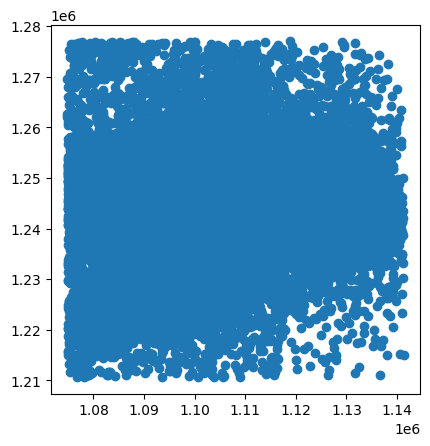

In [ ]:
gdf = gpd.GeoDataFrame(data= df_Filtrado_100km, geometry=puntosSismos)
gdf.to_crs(epsg='3116', inplace=True)
gdf.plot()

In [ ]:
gdf['X'] = gdf.get_coordinates()['x']
gdf['Y'] = gdf.get_coordinates()['y']
gdf['Z'] = gdf['PROFUNDIDAD (Km)'] * 1000
gdf.head()

FECHA  HORA_UTC  LATITUD (grados)  LONGITUD (grados)  \
0  1994-01-01  00:06:37             6.839            -72.950   
1  1994-01-01  08:17:30             6.877            -72.912   
2  1994-01-02  01:55:17             6.806            -72.898   
3  1994-01-02  04:49:35             6.898            -73.095   
4  1994-01-02  05:55:47             6.736            -73.201   

   PROFUNDIDAD (Km)  MAGNITUD Ml  ERROR LATITUD (Km)  ERROR LONGITUD (Km)  \
0             158.6          3.7                15.8                 17.2   
1             166.6          4.1                14.7                 19.9   
2             150.0          3.0                12.8                 15.8   
3             150.0          3.1                 8.3                  8.7   
4             150.0          5.3                17.1                 18.0   

   ERROR PROFUNDIDAD (Km)           Date-Time  \
0                    19.5 1994-01-01 00:06:37   
1                    16.2 1994-01-01 08:17:30   
2                    17.8 1994-01-02 01:55:17   
3                    11.3 1994-01-02 04:49:35   
4                    24.7 1994-01-02 05:55:47   

                          geometry             X             Y         Z  
0  POINT (1124634.322 1248167.015)  1.124634e+06  1.248167e+06  158600.0  
1  POINT (1128825.175 1252380.301)  1.128825e+06  1.252380e+06  166600.0  
2  POINT (1130392.089 1244530.574)  1.130392e+06  1.244531e+06  150000.0  
3  POINT (1108591.040 1254657.620)  1.108591e+06  1.254658e+06  150000.0  
4  POINT (1096907.050 1236717.171)  1.096907e+06  1.236717e+06  150000.0

######## 
  1994
R2 RegLin 0.22122001313343564
R2 Ransac 0.007981640428278869
R2 Ridge 0.2212200131334363
R2 Lasso 0.22122001313343598


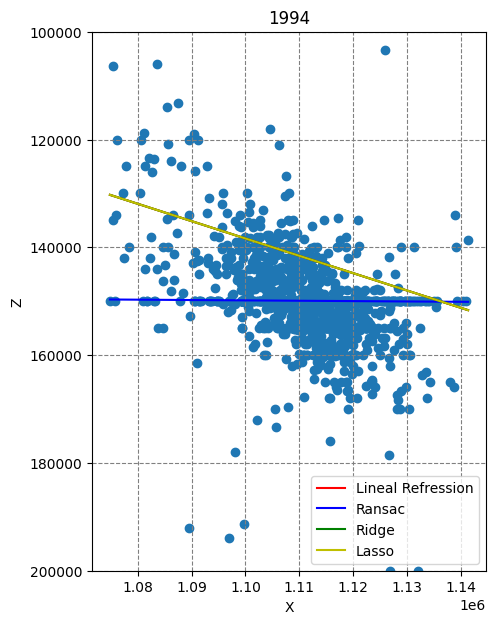

######## 
  1995
R2 RegLin 0.21714853421525893
R2 Ransac -0.03499187462219555
R2 Ridge 0.21714853421525893
R2 Lasso 0.21714853421525893


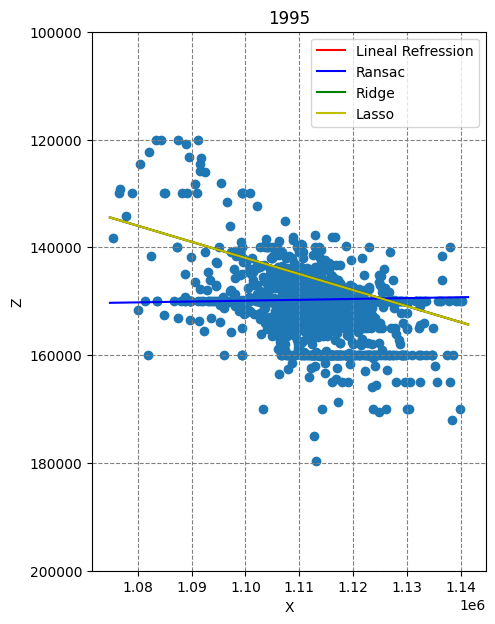

######## 
  1996
R2 RegLin 0.28636731439919416
R2 Ransac 0.232685853790621
R2 Ridge 0.28636731439919405
R2 Lasso 0.28636731439919505


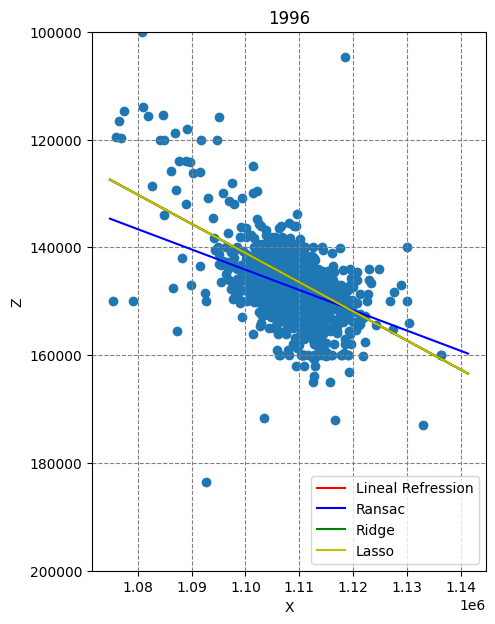

######## 
  1997
R2 RegLin 0.244292447844357
R2 Ransac 0.15011288289840818
R2 Ridge 0.244292447844356
R2 Lasso 0.2442924478443571


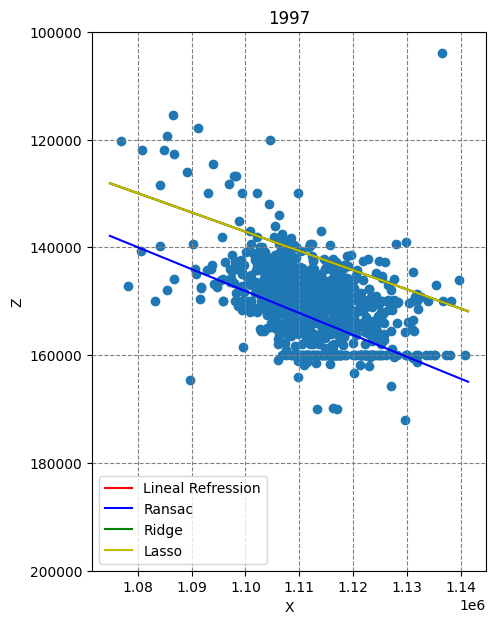

######## 
  1998
R2 RegLin 0.24176450559719342
R2 Ransac 0.03935700037725298
R2 Ridge 0.24176450559719342
R2 Lasso 0.24176450559719342


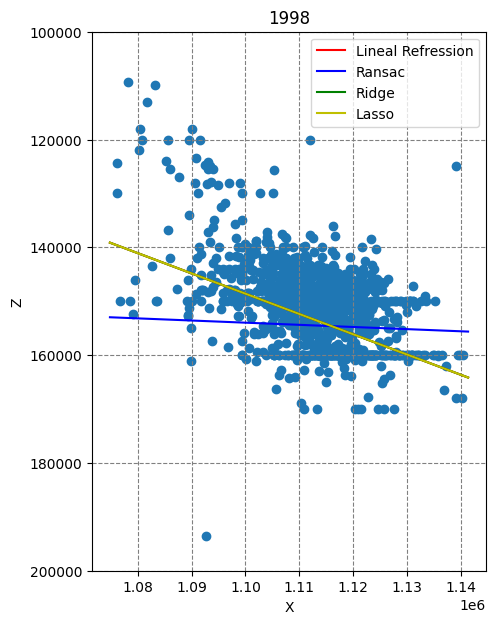

######## 
  1999
R2 RegLin 0.1683045530641385
R2 Ransac 0.1361005185682096
R2 Ridge 0.1683045530641385
R2 Lasso 0.1683045530641385


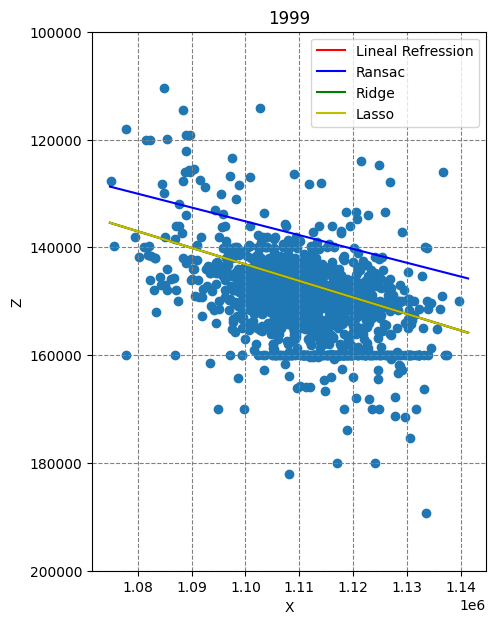

######## 
  2000
R2 RegLin 0.09865095255614387
R2 Ransac 0.007757936475255467
R2 Ridge 0.09865095255614376
R2 Lasso 0.09865095255614398


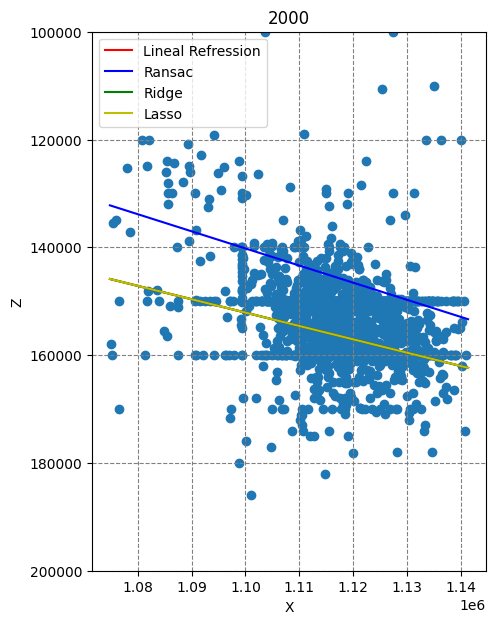

######## 
  2001
R2 RegLin 0.10497235596324783
R2 Ransac -0.039025528387680364
R2 Ridge 0.10497235596324783
R2 Lasso 0.10497235596324772


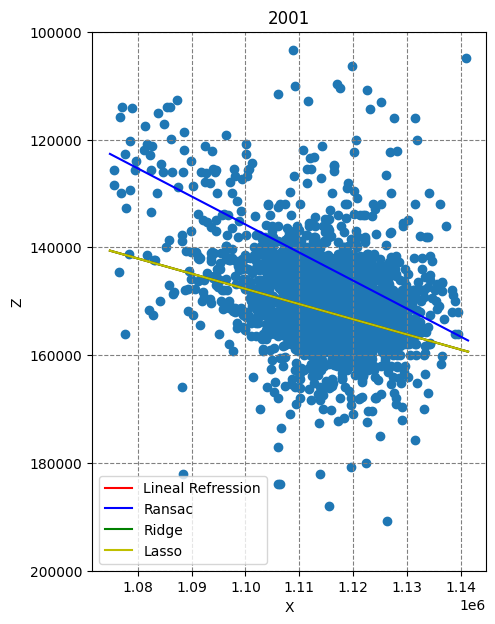

######## 
  2002
R2 RegLin 0.20817010047008944
R2 Ransac 0.07248482395843314
R2 Ridge 0.20817010047008966
R2 Lasso 0.20817010047008955


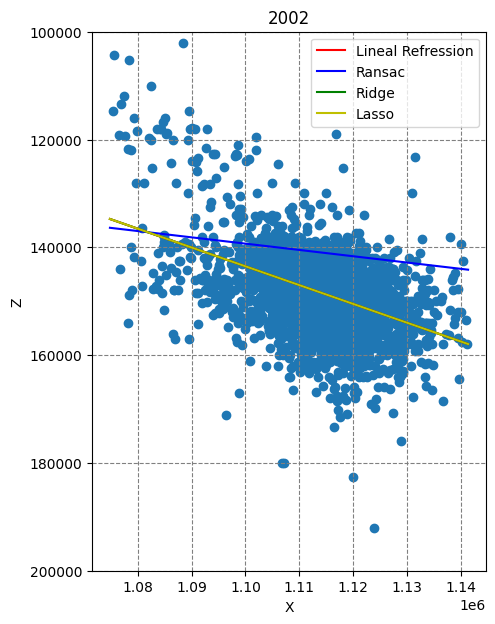

######## 
  2003
R2 RegLin 0.19908564939334472
R2 Ransac 0.12729235585349297
R2 Ridge 0.1990856493933444
R2 Lasso 0.1990856493933444


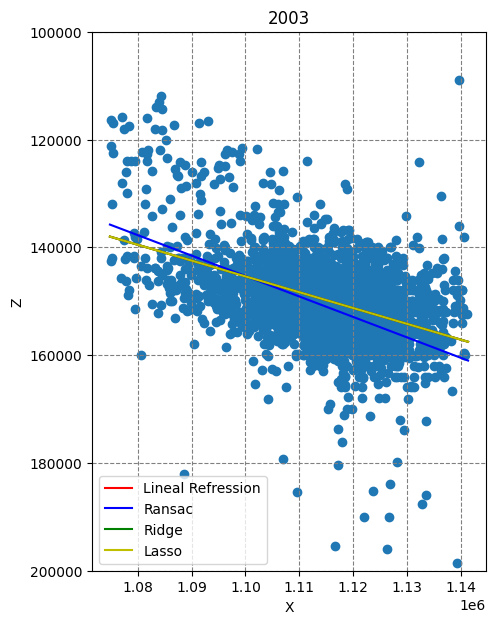

######## 
  2004
R2 RegLin 0.16618089199107833
R2 Ransac -0.04453675972605753
R2 Ridge 0.16618089199107844
R2 Lasso 0.16618089199107822


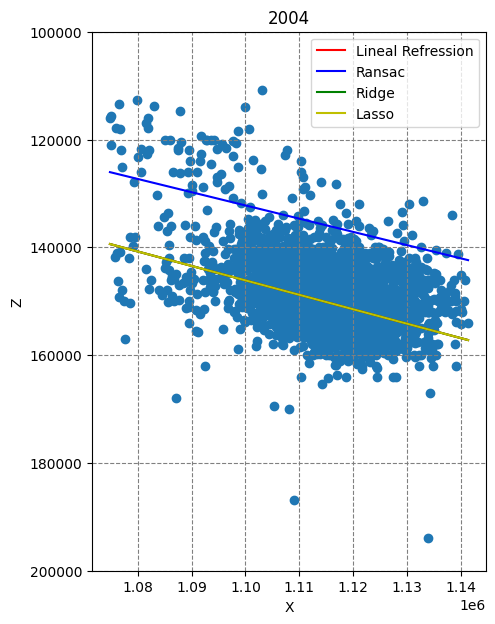

######## 
  2005
R2 RegLin 0.1874498277546861
R2 Ransac -0.104198806203331
R2 Ridge 0.187449827754686
R2 Lasso 0.1874498277546861


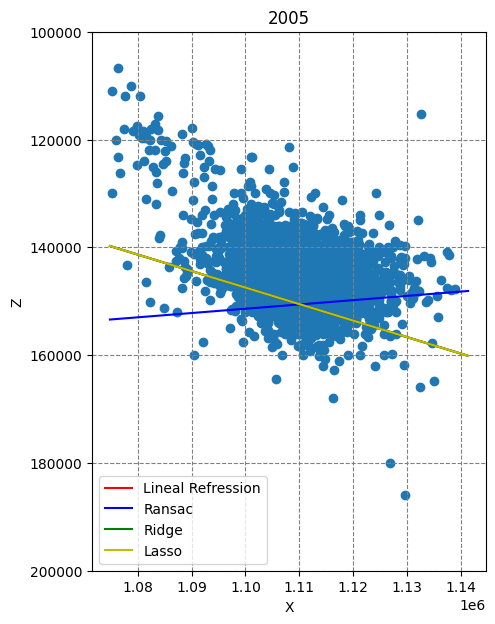

######## 
  2006
R2 RegLin 0.3348846849490775
R2 Ransac -0.06646576367633372
R2 Ridge 0.33488468494907775
R2 Lasso 0.33488468494907775


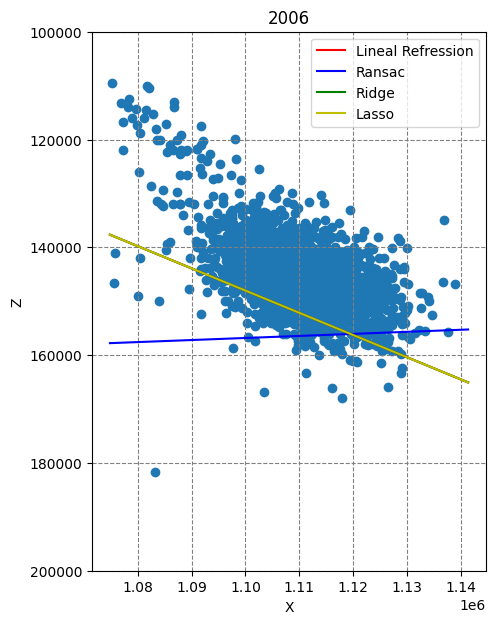

######## 
  2007
R2 RegLin 0.235431430351837
R2 Ransac 0.04988966472942158
R2 Ridge 0.23543143035183722
R2 Lasso 0.235431430351837


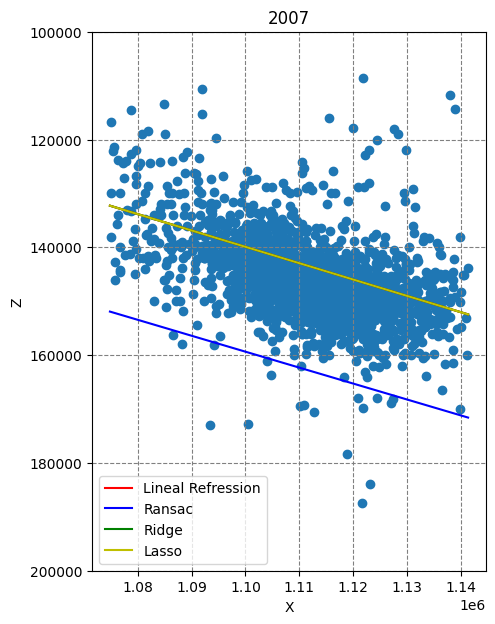

######## 
  2008
R2 RegLin 0.1791576435612353
R2 Ransac 0.14424856330111557
R2 Ridge 0.17915764356123542
R2 Lasso 0.1791576435612352


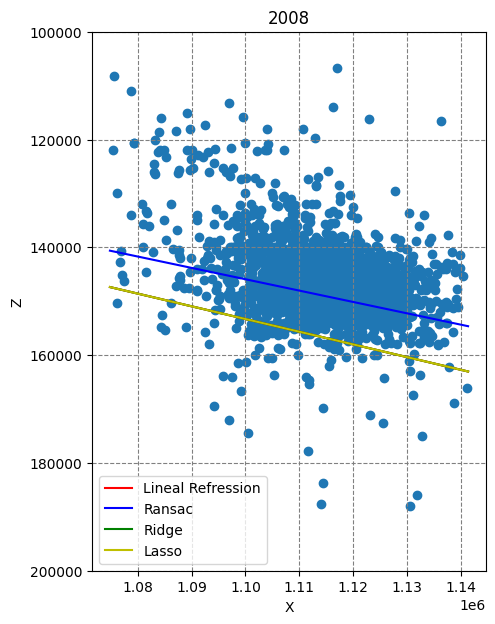

######## 
  2009
R2 RegLin 0.1334092880879556
R2 Ransac 0.004365040511577378
R2 Ridge 0.1334092880879556
R2 Lasso 0.1334092880879556


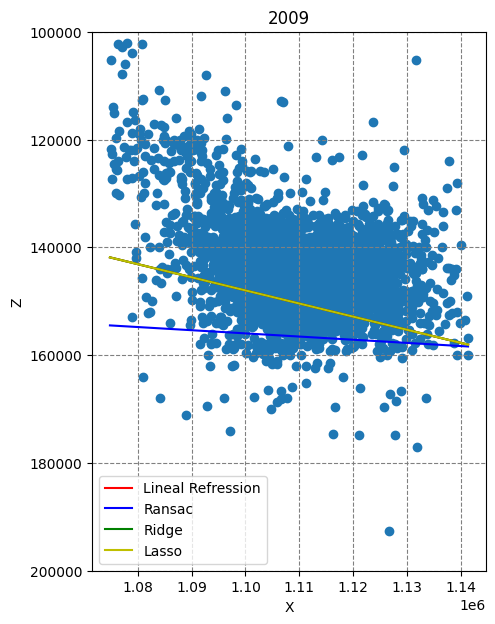

######## 
  2010
R2 RegLin 0.11058688125362182
R2 Ransac 0.08081022993925646
R2 Ridge 0.11058688125362182
R2 Lasso 0.11058688125362182


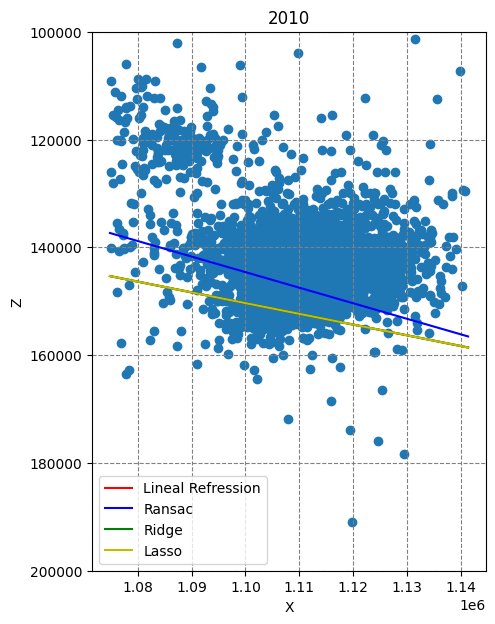

######## 
  2011
R2 RegLin 0.16524058172165867
R2 Ransac 0.10961739475620924
R2 Ridge 0.16524058172165867
R2 Lasso 0.16524058172165845


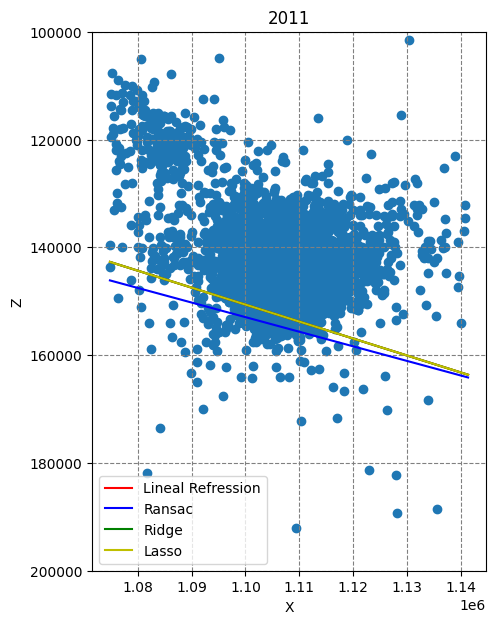

######## 
  2012
R2 RegLin 0.19748145047361987
R2 Ransac 0.04855297324261221
R2 Ridge 0.19748145047361976
R2 Lasso 0.19748145047361976


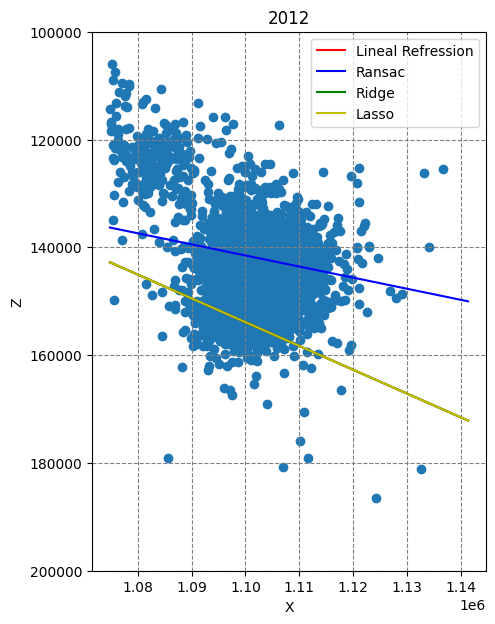

######## 
  2013
R2 RegLin 0.20250462684944914
R2 Ransac 0.19942529750845583
R2 Ridge 0.20250462684944914
R2 Lasso 0.2025046268494486


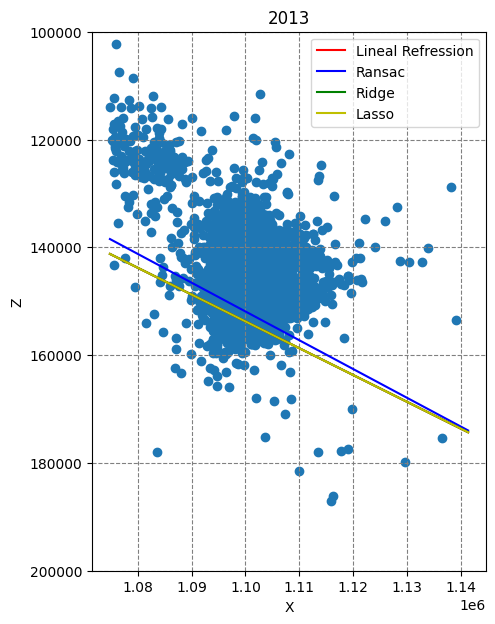

######## 
  2014
R2 RegLin 0.24801346457961815
R2 Ransac 0.134412226476319
R2 Ridge 0.24801346457961815
R2 Lasso 0.24801346457961793


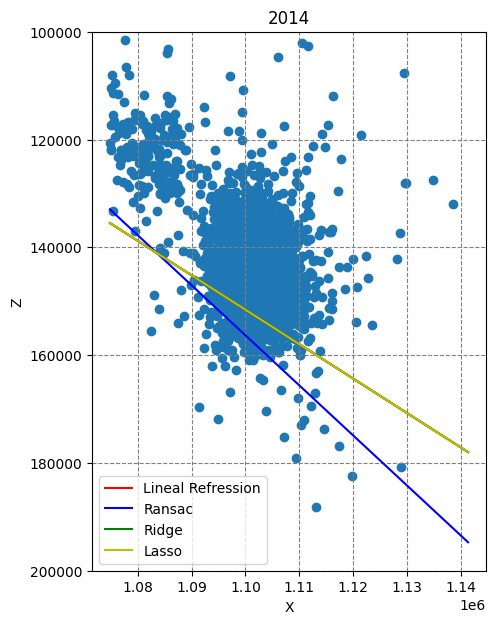

######## 
  2015
R2 RegLin 0.23618539868136557
R2 Ransac 0.13176765613106667
R2 Ridge 0.23618539868136523
R2 Lasso 0.23618539868136568


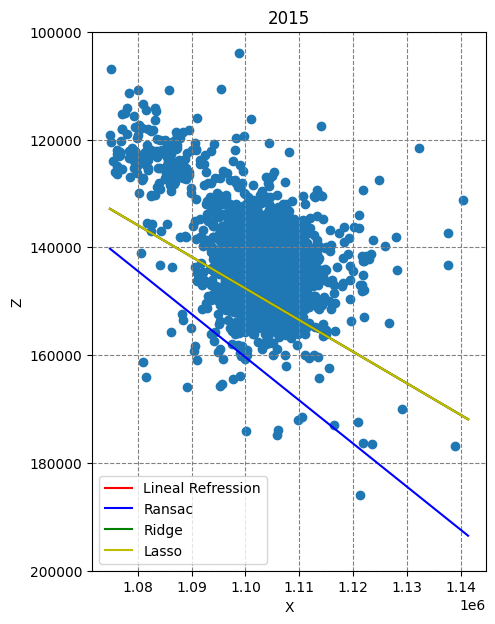

######## 
  2016
R2 RegLin 0.22355214359403497
R2 Ransac 0.19868591408831882
R2 Ridge 0.2235521435940352
R2 Lasso 0.22355214359403486


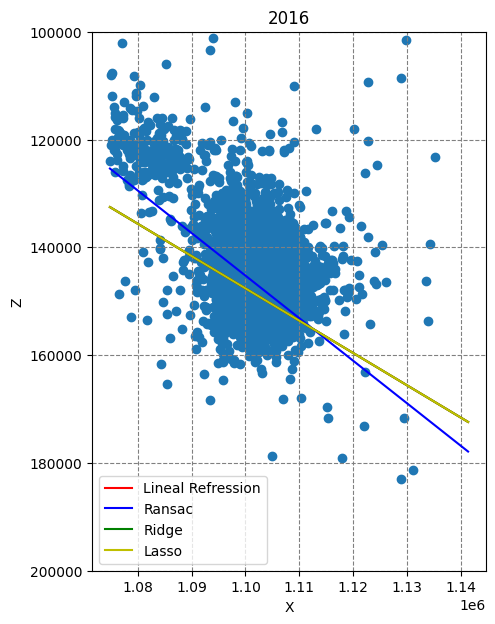

######## 
  2017
R2 RegLin 0.18716816141322945
R2 Ransac -0.0563943635533688
R2 Ridge 0.18716816141322934
R2 Lasso 0.18716816141322934


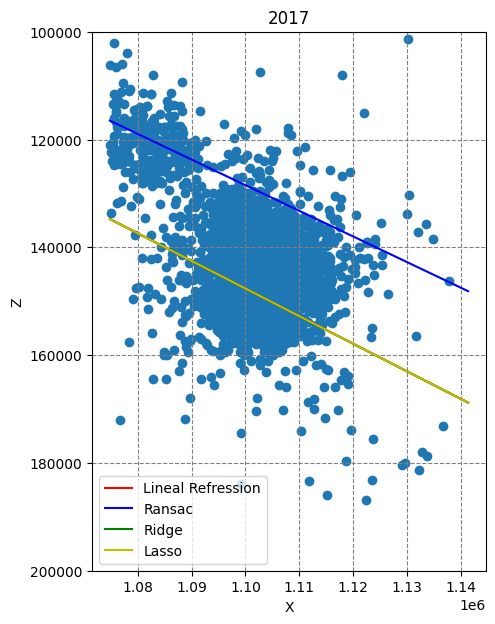

######## 
  2018
R2 RegLin 0.14538900709843383
R2 Ransac 0.08191780231921131
R2 Ridge 0.14538900709843383
R2 Lasso 0.14538900709843372


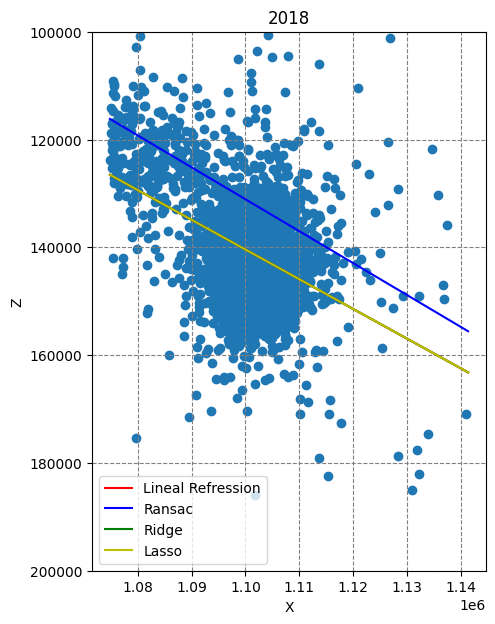

######## 
  2019
R2 RegLin 0.2106224635378925
R2 Ransac -0.030772923231488614
R2 Ridge 0.21062246353789238
R2 Lasso 0.2106224635378925


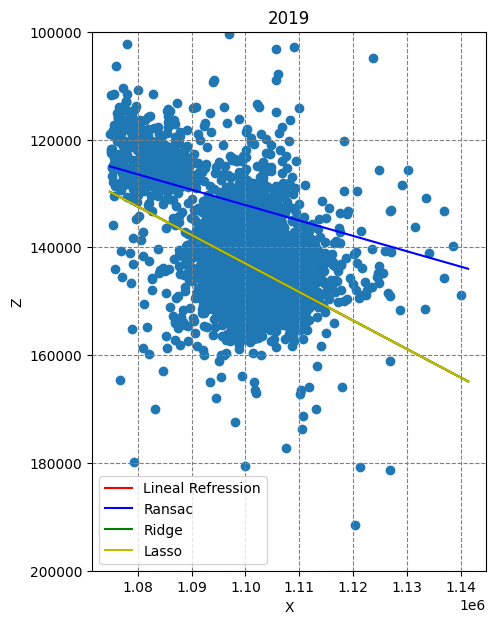

######## 
  2020
R2 RegLin 0.17282352495174624
R2 Ransac 0.030283819582093918
R2 Ridge 0.17282352495174624
R2 Lasso 0.17282352495174613


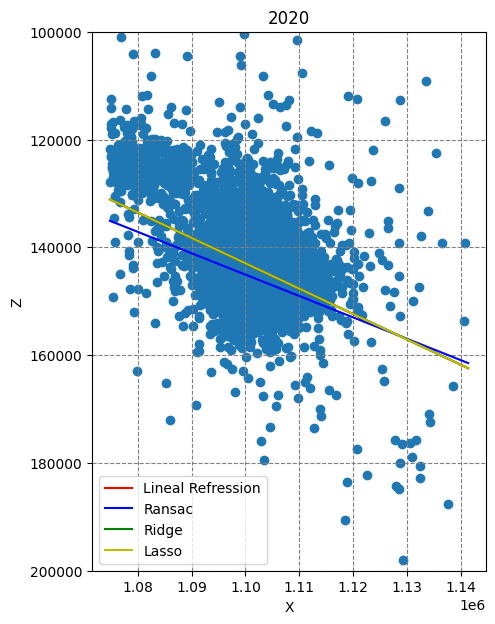

######## 
  2021
R2 RegLin 0.12854391886984629
R2 Ransac -0.07434410452339413
R2 Ridge 0.1285439188698465
R2 Lasso 0.1285439188698465


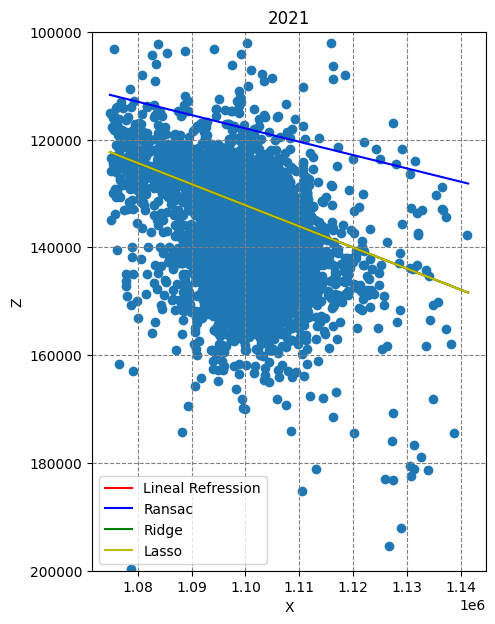

######## 
  2022
R2 RegLin 0.0801110673844746
R2 Ransac -0.0809536637933792
R2 Ridge 0.08011106738447471
R2 Lasso 0.08011106738447438


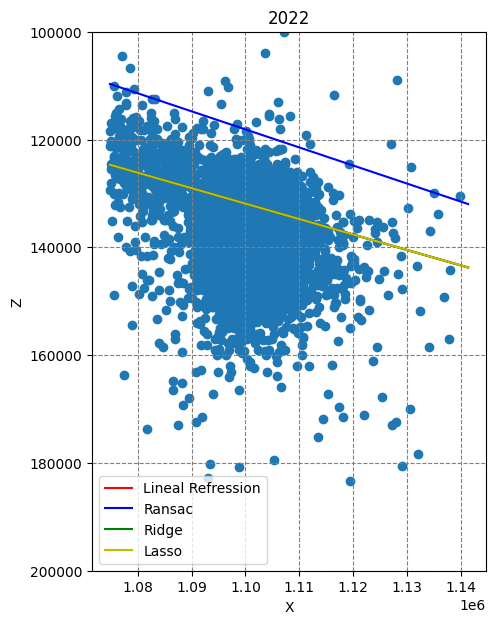

######## 
  2023
R2 RegLin 0.09734906732290283
R2 Ransac -0.6663280854376767
R2 Ridge 0.09734906732290283
R2 Lasso 0.09734906732290305


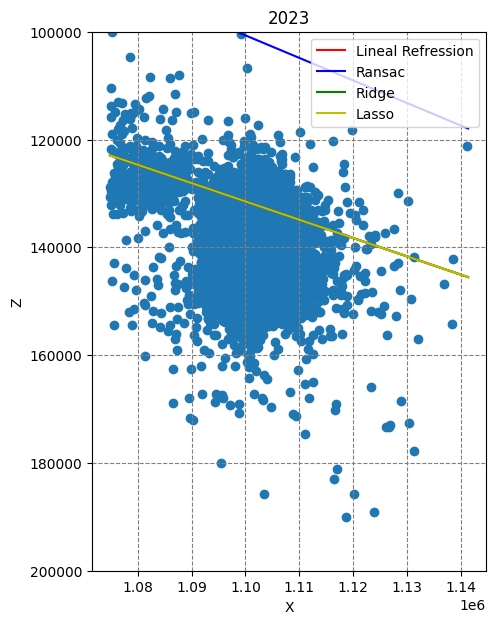

In [ ]:
# No resultó tan bueno el Ransac ... se toma la Lineal regresion normal

years = np.arange(1994, 2024, 1)
diccModeloLineal = {'year':[],
                    'wX':[],
                    'wY':[],
                    'R2':[],
                    'RMSE':[],
                    'b':[]}

puntosPred = np.array([[gdf['X'].min(), gdf['Y'].min()],
                        [gdf['X'].max(), gdf['Y'].min()]])

for year in years:
  gdf2 = gdf[gdf['Date-Time'].dt.year == year].copy()
  X = gdf2[['X', 'Y']].to_numpy()
  y = gdf2['Z'].to_numpy().reshape(-1, 1)



  # Fit line using all data
  model = linear_model.LinearRegression()
  model.fit(X, y)
  diccModeloLineal['year'].append(year)
  diccModeloLineal['wX'].append(model.coef_[0][0])
  diccModeloLineal['wY'].append(model.coef_[0][1])
  diccModeloLineal['b'].append(model.intercept_[0])

  # Robustly fit linear model with RANSAC algorithm
  model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression())
  model_ransac.fit(X, y)
  inlier_mask = model_ransac.inlier_mask_
  outlier_mask = np.logical_not(inlier_mask)

  # Ridge linear regrtesion l2
  modelRidge = linear_model.Ridge(alpha=0.1)
  modelRidge.fit(X, y)

  # Lasso linear regrtesion L1
  modelLasso = linear_model.Lasso(alpha=0.1)
  modelLasso.fit(X, y)

  # Predict data of estimated models
  line_y = model.predict(puntosPred)
  line_y_ransac = model_ransac.predict(puntosPred)
  line_y_ridge = modelRidge.predict(puntosPred)
  line_y_lasso = modelLasso.predict(puntosPred)
  print('######## \n ', year)
  print('R2 RegLin', r2_score(y, model.predict(X)))
  print('R2 Ransac', r2_score(y, model_ransac.predict(X)))
  print('R2 Ridge', r2_score(y, modelRidge.predict(X)))
  print('R2 Lasso', r2_score(y, modelLasso.predict(X)))

  # Errores
  diccModeloLineal['R2'].append(r2_score(y, model.predict(X)))
  diccModeloLineal['RMSE'].append(np.sqrt(mean_squared_error(y, model.predict(X))))


  # Plot
  fig, ax = plt.subplots(1,1,figsize=(7,7))
  ax.scatter(X[:, 0], y)
  ax.plot(puntosPred[:,0], line_y, color='r', label='Lineal Refression')
  ax.plot(puntosPred[:,0], line_y_ransac, color='b', label='Ransac')
  ax.plot(puntosPred[:,0], line_y_ridge, color='g', label='Ridge')
  ax.plot(puntosPred[:,0], line_y_lasso, color='y', label='Lasso')

  ax.legend()
  ax.grid(ls='--', c='grey')
  ax.invert_yaxis()
  ax.set_ylim(200000, 100000)
  ax.set_aspect('equal')
  ax.set_xlabel('X')
  ax.set_ylabel('Z')
  plt.title(year)
  plt.show()


In [ ]:
df_ModeloLineal = pd.DataFrame(diccModeloLineal)
df_ModeloLineal

year        wX        wY        R2         RMSE              b
0   1994  0.321956  0.230626  0.221220  6842.780595 -494994.910327
1   1995  0.298740  0.143266  0.217149  5073.923027 -360083.909299
2   1996  0.541654  0.059751  0.286367  5565.176369 -527096.596326
3   1997  0.357316  0.236932  0.244292  5981.828803 -542788.280474
4   1998  0.376552 -0.070478  0.241765  6724.810482 -180282.416973
5   1999  0.307105  0.087285  0.168305  6676.108719 -300322.666633
6   2000  0.248122 -0.080495  0.098651  8050.065185  -23372.533984
7   2001  0.282125 -0.066452  0.104972  8190.243280  -82180.651023
8   2002  0.349150  0.018364  0.208170  6481.509381 -262775.720951
9   2003  0.293676  0.011745  0.199086  6544.419910 -191870.101171
10  2004  0.268132 -0.050596  0.166181  6049.370381  -87560.589354
11  2005  0.306526 -0.144599  0.187450  5547.146833  -14654.979554
12  2006  0.412439 -0.181817  0.334885  5194.493397  -85543.309382
13  2007  0.303583  0.077259  0.235431  6628.481162 -287565.693987
14  2008  0.235780 -0.291406  0.179158  6574.624830  246724.568600
15  2009  0.243701 -0.167230  0.133409  7009.680086   82372.169756
16  2010  0.199307 -0.281535  0.110587  6389.731514  271944.275927
17  2011  0.315091 -0.307656  0.165241  6335.785336  176480.916630
18  2012  0.441918 -0.334728  0.197481  5853.838685   73005.247472
19  2013  0.497876 -0.295936  0.202505  5563.157877  -35652.139738
20  2014  0.639543 -0.265696  0.248013  6116.799626 -230261.878369
21  2015  0.587581 -0.154579  0.236185  5945.957028 -311571.419306
22  2016  0.599984 -0.141964  0.223552  6223.585685 -340501.266035
23  2017  0.512638 -0.148909  0.187168  6479.259053 -235983.945302
24  2018  0.551763  0.052818  0.145389  7269.509475 -530475.013641
25  2019  0.529594 -0.005654  0.210622  5929.722270 -432703.268011
26  2020  0.471272  0.001356  0.172824  6096.313806 -377080.193010
27  2021  0.392323  0.220121  0.128544  7705.611968 -565844.464525
28  2022  0.286885  0.201281  0.080111  6900.544152 -427356.044747
29  2023  0.340097  0.261811  0.097349  6628.853885 -559577.921824

In [ ]:
v_y = np.array([0,1])#.reshape(2,1)

prodPunto = np.dot(df_ModeloLineal[['wX', 'wY']].to_numpy(), v_y)
prodNormas = np.linalg.norm(df_ModeloLineal[['wX', 'wY']].to_numpy(), axis=1) * np.linalg.norm(v_y)
rumboGrados = np.rad2deg(np.arccos(prodPunto/prodNormas))
#rumboGrados

In [ ]:
pesos = df_ModeloLineal.loc[0, ['wX', 'wY']].to_numpy()
print(pesos[0]*0 + pesos[1]*0)
print(pesos[0]*pesos[0] + pesos[1]*pesos[1])
print(np.linalg.norm(pesos))
print(np.arctan((pesos[0]*pesos[0] + pesos[1]*pesos[1]) / np.linalg.norm(pesos)))
print(np.rad2deg(np.arctan((pesos[0]*pesos[0] + pesos[1]*pesos[1]) / np.linalg.norm(pesos))))

0.0
0.15684447938309226
0.396035957184562
0.3770844346697816
21.605346626655102


In [ ]:
pesos = df_ModeloLineal[['wX', 'wY']].to_numpy()
normaPesos = np.linalg.norm(pesos, axis=1)
z_pred = pesos[:,0]*pesos[:,0] + pesos[:,1]*pesos[:,1]
buzamientoGrados = np.rad2deg(np.arctan(z_pred/normaPesos))
#buzamientoGrados

In [ ]:
df_ModeloLineal['DipDir'] = np.round(rumboGrados,0).astype(int)
df_ModeloLineal['Dip'] = np.round(buzamientoGrados,0).astype(int)
df_ModeloLineal

year        wX        wY        R2         RMSE              b  DipDir  \
0   1994  0.321956  0.230626  0.221220  6842.780595 -494994.910327      54   
1   1995  0.298740  0.143266  0.217149  5073.923027 -360083.909299      64   
2   1996  0.541654  0.059751  0.286367  5565.176369 -527096.596326      84   
3   1997  0.357316  0.236932  0.244292  5981.828803 -542788.280474      56   
4   1998  0.376552 -0.070478  0.241765  6724.810482 -180282.416973     101   
5   1999  0.307105  0.087285  0.168305  6676.108719 -300322.666633      74   
6   2000  0.248122 -0.080495  0.098651  8050.065185  -23372.533984     108   
7   2001  0.282125 -0.066452  0.104972  8190.243280  -82180.651023     103   
8   2002  0.349150  0.018364  0.208170  6481.509381 -262775.720951      87   
9   2003  0.293676  0.011745  0.199086  6544.419910 -191870.101171      88   
10  2004  0.268132 -0.050596  0.166181  6049.370381  -87560.589354     101   
11  2005  0.306526 -0.144599  0.187450  5547.146833  -14654.979554     115   
12  2006  0.412439 -0.181817  0.334885  5194.493397  -85543.309382     114   
13  2007  0.303583  0.077259  0.235431  6628.481162 -287565.693987      76   
14  2008  0.235780 -0.291406  0.179158  6574.624830  246724.568600     141   
15  2009  0.243701 -0.167230  0.133409  7009.680086   82372.169756     124   
16  2010  0.199307 -0.281535  0.110587  6389.731514  271944.275927     145   
17  2011  0.315091 -0.307656  0.165241  6335.785336  176480.916630     134   
18  2012  0.441918 -0.334728  0.197481  5853.838685   73005.247472     127   
19  2013  0.497876 -0.295936  0.202505  5563.157877  -35652.139738     121   
20  2014  0.639543 -0.265696  0.248013  6116.799626 -230261.878369     113   
21  2015  0.587581 -0.154579  0.236185  5945.957028 -311571.419306     105   
22  2016  0.599984 -0.141964  0.223552  6223.585685 -340501.266035     103   
23  2017  0.512638 -0.148909  0.187168  6479.259053 -235983.945302     106   
24  2018  0.551763  0.052818  0.145389  7269.509475 -530475.013641      85   
25  2019  0.529594 -0.005654  0.210622  5929.722270 -432703.268011      91   
26  2020  0.471272  0.001356  0.172824  6096.313806 -377080.193010      90   
27  2021  0.392323  0.220121  0.128544  7705.611968 -565844.464525      61   
28  2022  0.286885  0.201281  0.080111  6900.544152 -427356.044747      55   
29  2023  0.340097  0.261811  0.097349  6628.853885 -559577.921824      52   

    Dip  
0    22  
1    18  
2    29  
3    23  
4    21  
5    18  
6    15  
7    16  
8    19  
9    16  
10   15  
11   19  
12   24  
13   17  
14   21  
15   16  
16   19  
17   24  
18   29  
19   30  
20   35  
21   31  
22   32  
23   28  
24   29  
25   28  
26   25  
27   24  
28   19  
29   23

In [ ]:
df_ModeloLineal.to_csv(pathDatos+'df_DirBuzPlanos_todosML.csv', index=False)

# Ml 4.5

In [ ]:
# Se carga el catalogo de los eventos de prof mayores a 100 km
df_todos = pd.read_csv(pathDatos+'df_Total_1994_2024.csv')
df_todos['Date-Time'] = pd.to_datetime(df_todos['Date-Time'], yearfirst=True)
df_todos.dropna(inplace=True)
df_todos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 148910 entries, 0 to 148985
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   FECHA                   148910 non-null  object        
 1   HORA_UTC                148910 non-null  object        
 2   LATITUD (grados)        148910 non-null  float64       
 3   LONGITUD (grados)       148910 non-null  float64       
 4   PROFUNDIDAD (Km)        148910 non-null  float64       
 5   MAGNITUD Ml             148910 non-null  float64       
 6   ERROR LATITUD (Km)      148910 non-null  float64       
 7   ERROR LONGITUD (Km)     148910 non-null  float64       
 8   ERROR PROFUNDIDAD (Km)  148910 non-null  float64       
 9   Date-Time               148910 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(7), object(2)
memory usage: 12.5+ MB


In [ ]:
df_Filtrado_100km = df_todos[df_todos['PROFUNDIDAD (Km)'] >= 100]
df_Filtrado_100km_25ml = df_Filtrado_100km[df_Filtrado_100km['MAGNITUD Ml'] >= 4.5]
df_Filtrado_100km_25ml

FECHA  HORA_UTC  LATITUD (grados)  LONGITUD (grados)  \
4       1994-01-02  05:55:47             6.736            -73.201   
17      1994-01-05  14:28:07             6.706            -73.038   
42      1994-01-11  16:03:52             6.645            -73.029   
48      1994-01-12  20:34:43             6.848            -73.039   
204     1994-02-17  06:00:05             6.754            -73.107   
...            ...       ...               ...                ...   
144064  2023-11-04  11:00:36             6.782            -73.217   
147395  2024-01-21  17:19:49             6.797            -73.143   
147438  2024-01-22  19:05:50             6.799            -73.245   
148543  2024-02-20  01:38:03             6.773            -73.218   
148631  2024-02-22  04:05:32             6.786            -73.232   

        PROFUNDIDAD (Km)  MAGNITUD Ml  ERROR LATITUD (Km)  \
4                 150.00          5.3              17.100   
17                155.00          4.8              13.400   
42                155.00          4.6              19.900   
48                165.00          4.5              14.600   
204               156.00          4.9              16.800   
...                  ...          ...                 ...   
144064            146.05          4.7               2.069   
147395            148.53          5.0               0.990   
147438            147.75          4.5               1.724   
148543            147.29          4.6               1.884   
148631            146.99          4.7               1.908   

        ERROR LONGITUD (Km)  ERROR PROFUNDIDAD (Km)           Date-Time  
4                    18.000                   24.70 1994-01-02 05:55:47  
17                   15.000                   19.00 1994-01-05 14:28:07  
42                   20.900                   25.60 1994-01-11 16:03:52  
48                   15.100                   18.30 1994-01-12 20:34:43  
204                  18.600                   23.60 1994-02-17 06:00:05  
...                     ...                     ...                 ...  
144064                2.762                    3.75 2023-11-04 11:00:36  
147395                0.990                    1.40 2024-01-21 17:19:49  
147438                2.881                    3.81 2024-01-22 19:05:50  
148543                2.815                    3.76 2024-02-20 01:38:03  
148631                2.929                    4.59 2024-02-22 04:05:32  

[501 rows x 10 columns]

In [ ]:
puntosSismos = gpd.points_from_xy(df_Filtrado_100km_25ml['LONGITUD (grados)'],
                                  df_Filtrado_100km_25ml['LATITUD (grados)'],
                                  crs='epsg:4326')
puntosSismos

<GeometryArray>
[<POINT (-73.201 6.736)>, <POINT (-73.038 6.706)>, <POINT (-73.029 6.645)>,
 <POINT (-73.039 6.848)>, <POINT (-73.107 6.754)>, <POINT (-73.311 6.742)>,
 <POINT (-73.255 6.627)>,  <POINT (-73.16 6.819)>,   <POINT (-72.899 6.9)>,
  <POINT (-73.06 6.749)>,
 ...
 <POINT (-73.198 6.795)>, <POINT (-73.194 6.803)>, <POINT (-73.238 6.804)>,
 <POINT (-73.232 6.795)>, <POINT (-73.241 6.774)>, <POINT (-73.217 6.782)>,
 <POINT (-73.143 6.797)>, <POINT (-73.245 6.799)>, <POINT (-73.218 6.773)>,
 <POINT (-73.232 6.786)>]
Length: 501, dtype: geometry

<Axes: >

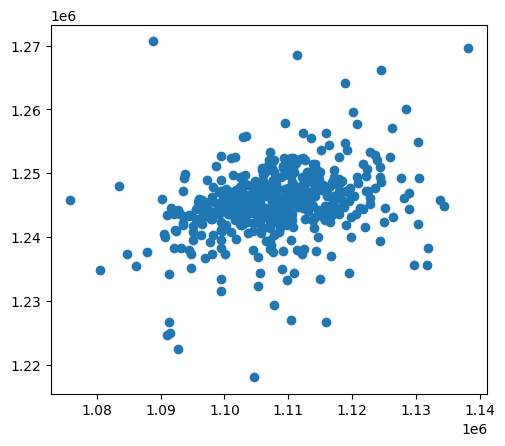

In [ ]:
gdf = gpd.GeoDataFrame(data= df_Filtrado_100km_25ml, geometry=puntosSismos)
gdf.to_crs(epsg='3116', inplace=True)
gdf.plot()

In [ ]:
gdf['X'] = gdf.get_coordinates()['x']
gdf['Y'] = gdf.get_coordinates()['y']
gdf['Z'] = gdf['PROFUNDIDAD (Km)'] * 1000
gdf.head()

FECHA  HORA_UTC  LATITUD (grados)  LONGITUD (grados)  \
4    1994-01-02  05:55:47             6.736            -73.201   
17   1994-01-05  14:28:07             6.706            -73.038   
42   1994-01-11  16:03:52             6.645            -73.029   
48   1994-01-12  20:34:43             6.848            -73.039   
204  1994-02-17  06:00:05             6.754            -73.107   

     PROFUNDIDAD (Km)  MAGNITUD Ml  ERROR LATITUD (Km)  ERROR LONGITUD (Km)  \
4               150.0          5.3                17.1                 18.0   
17              155.0          4.8                13.4                 15.0   
42              155.0          4.6                19.9                 20.9   
48              165.0          4.5                14.6                 15.1   
204             156.0          4.9                16.8                 18.6   

     ERROR PROFUNDIDAD (Km)           Date-Time  \
4                      24.7 1994-01-02 05:55:47   
17                     19.0 1994-01-05 14:28:07   
42                     25.6 1994-01-11 16:03:52   
48                     18.3 1994-01-12 20:34:43   
204                    23.6 1994-02-17 06:00:05   

                            geometry             X             Y         Z  
4    POINT (1096907.050 1236717.171)  1.096907e+06  1.236717e+06  150000.0  
17   POINT (1114937.223 1233434.302)  1.114937e+06  1.233434e+06  155000.0  
42   POINT (1115946.806 1226689.367)  1.115947e+06  1.226689e+06  155000.0  
48   POINT (1114793.045 1249140.336)  1.114793e+06  1.249140e+06  165000.0  
204  POINT (1107296.691 1238727.715)  1.107297e+06  1.238728e+06  156000.0

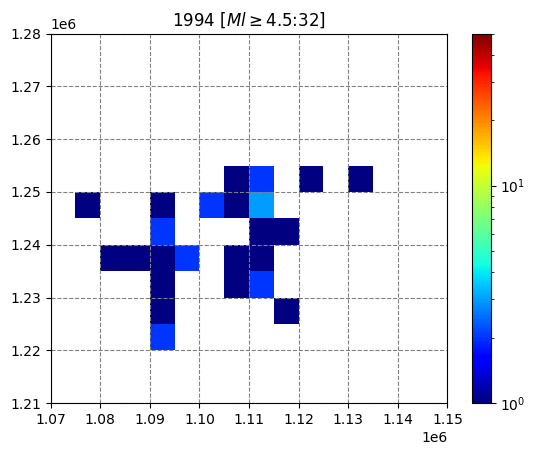

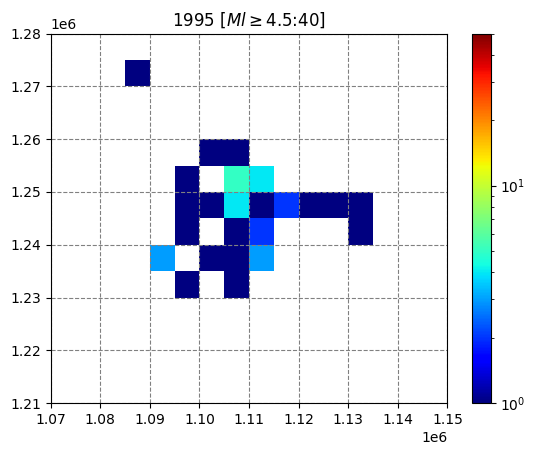

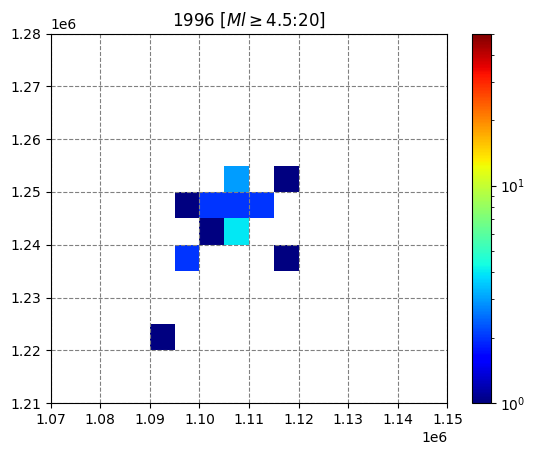

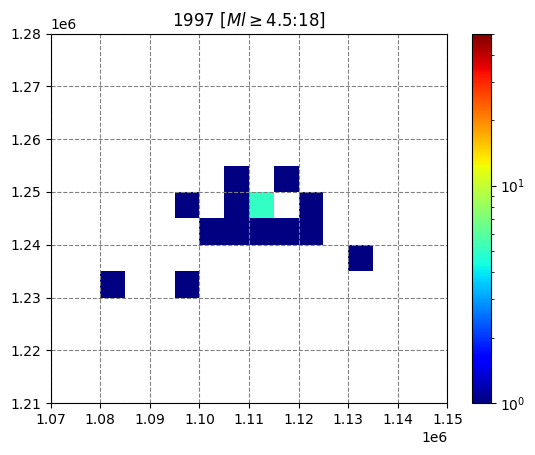

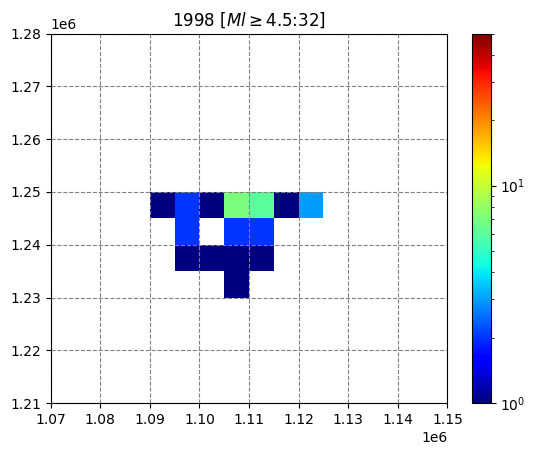

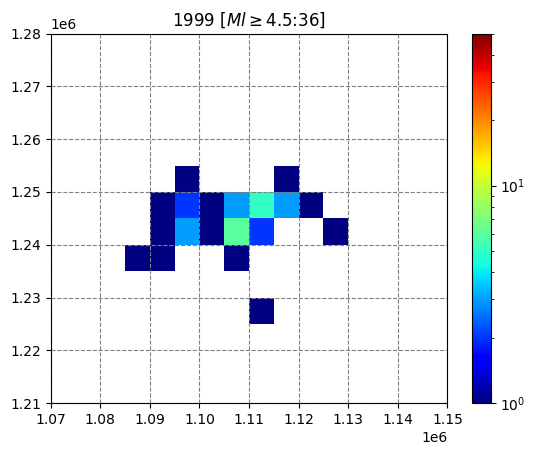

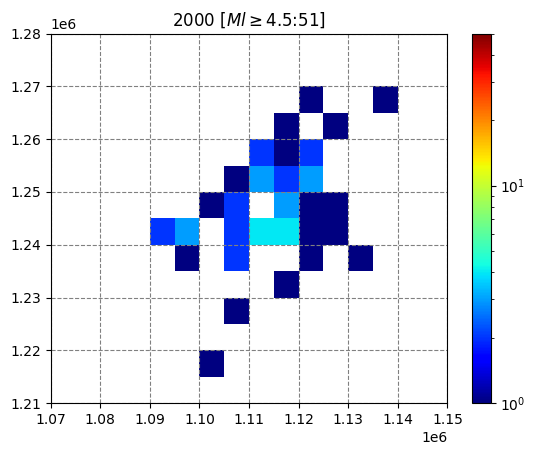

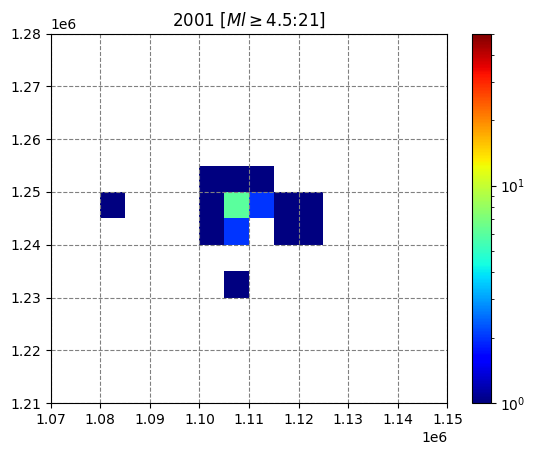

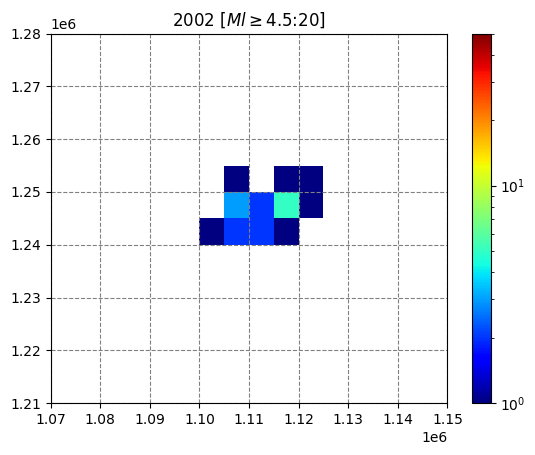

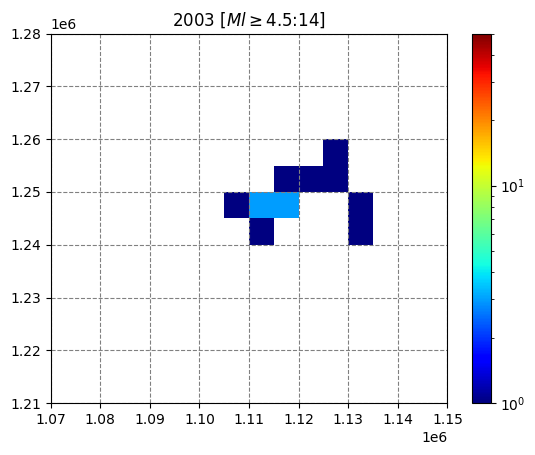

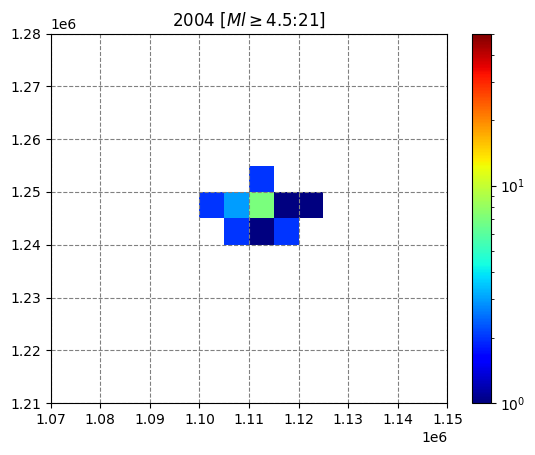

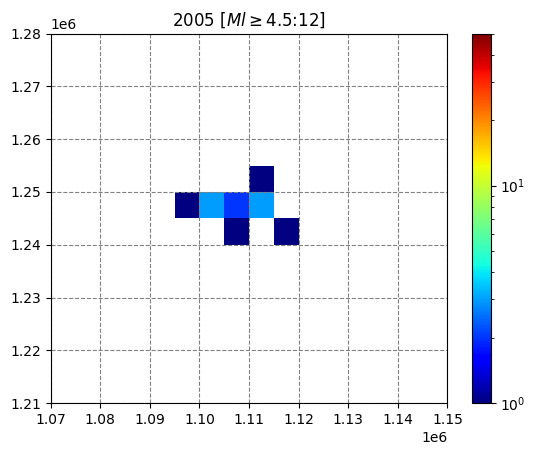

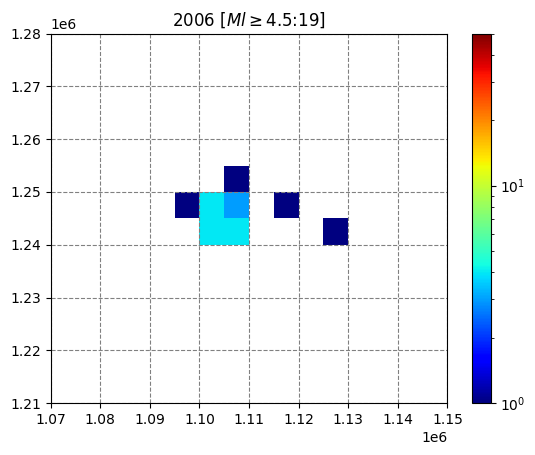

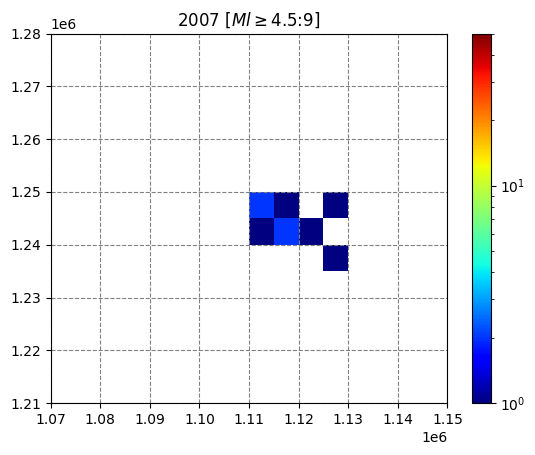

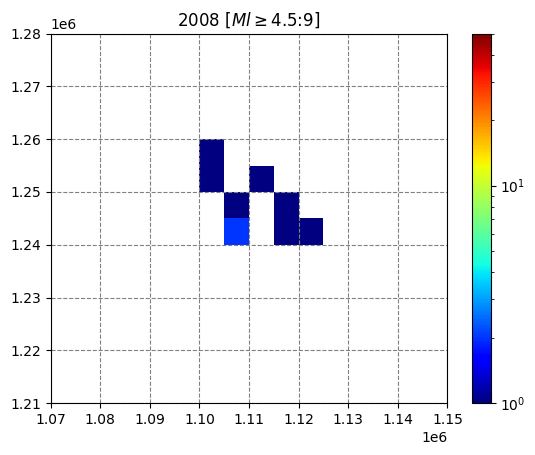

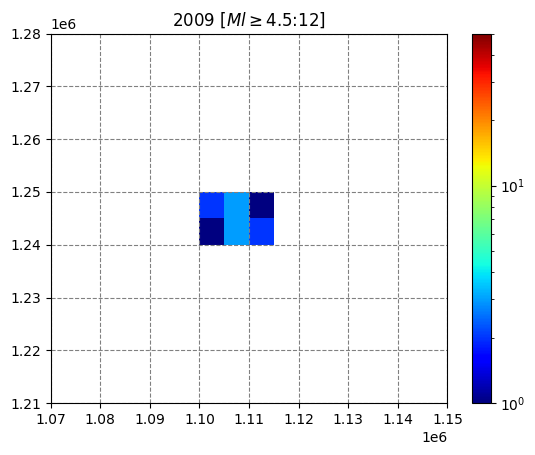

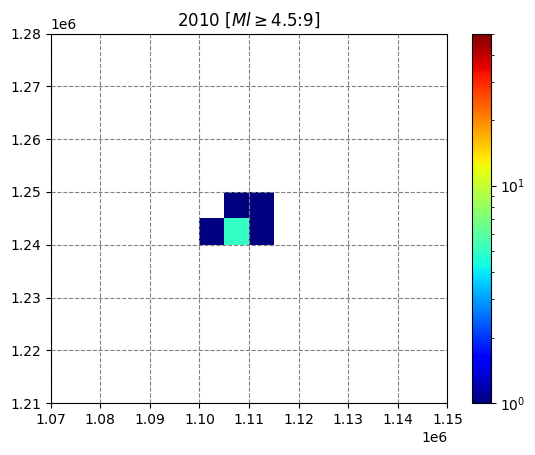

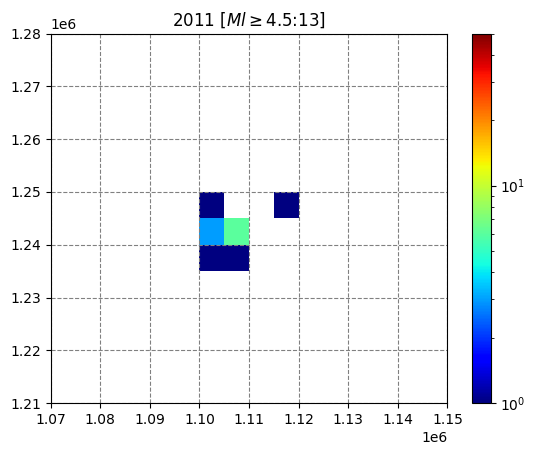

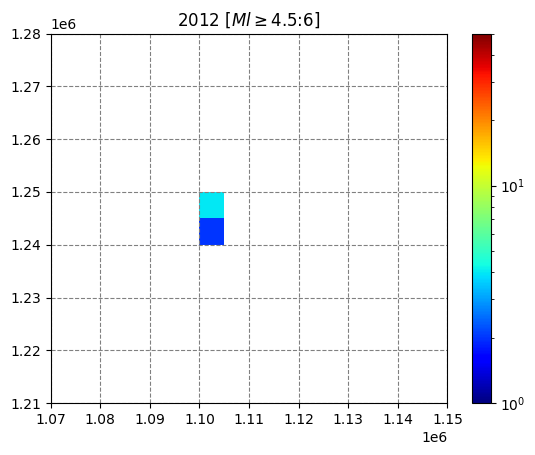

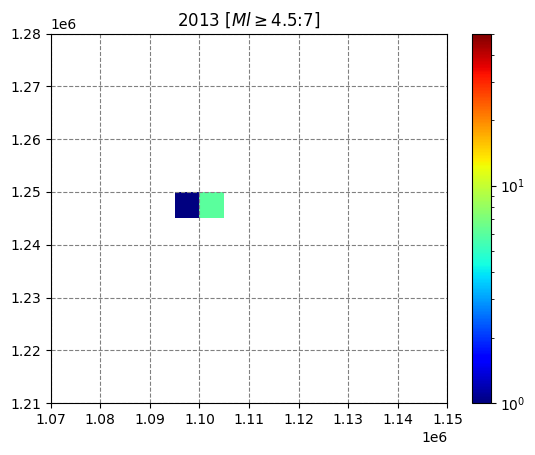

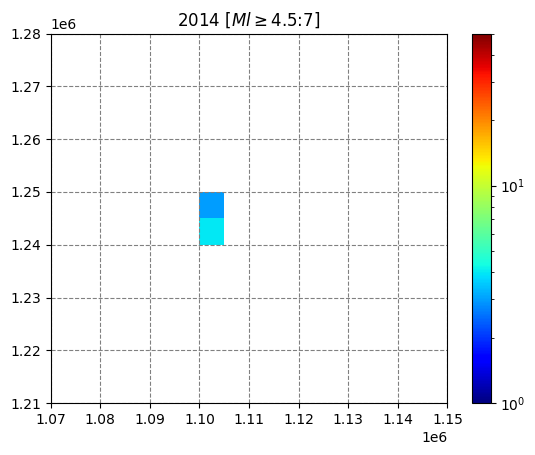

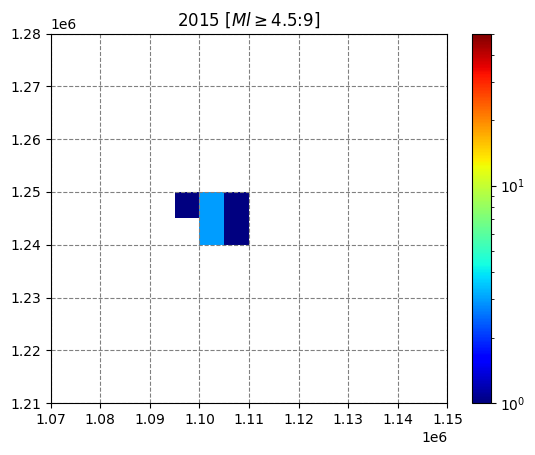

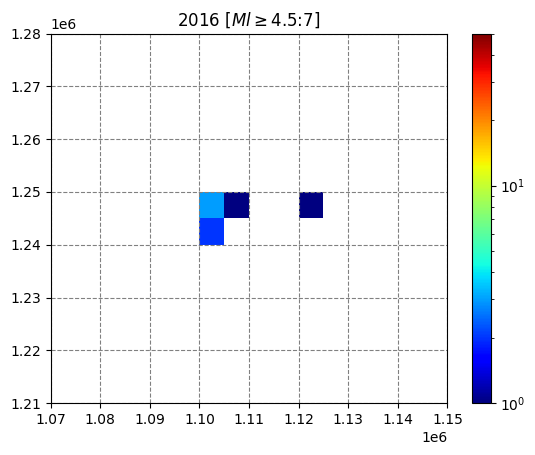

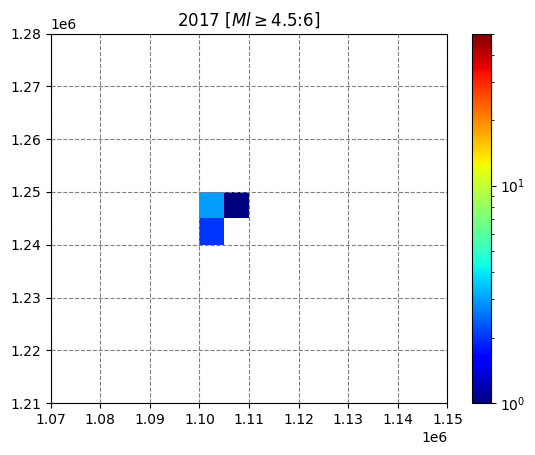

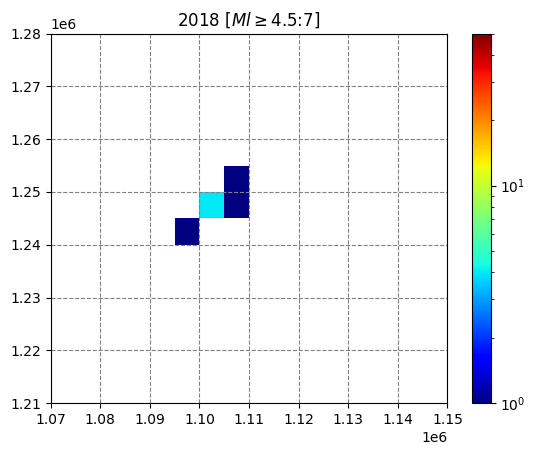

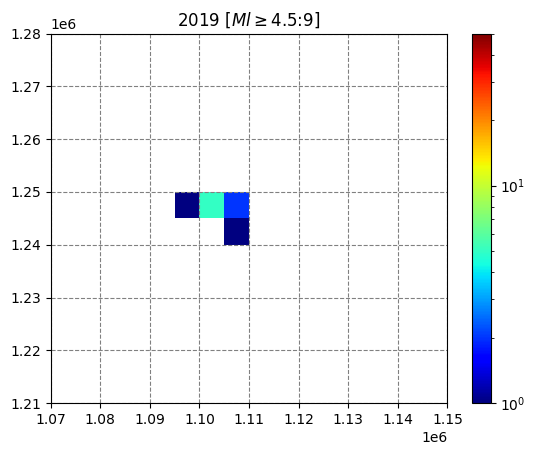

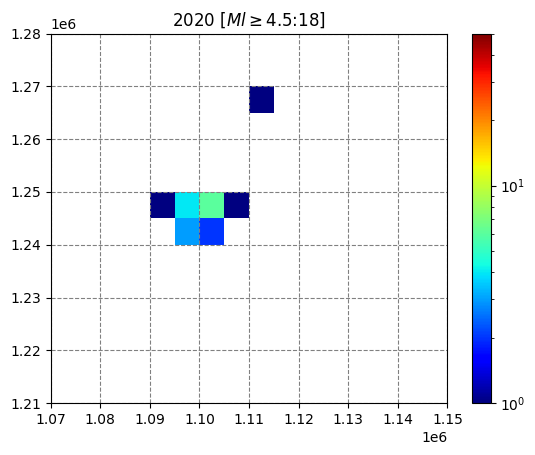

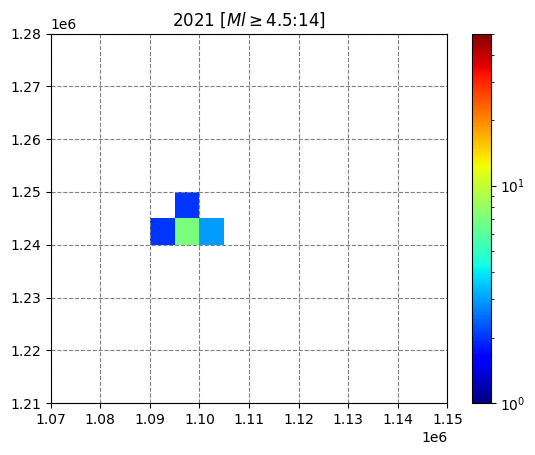

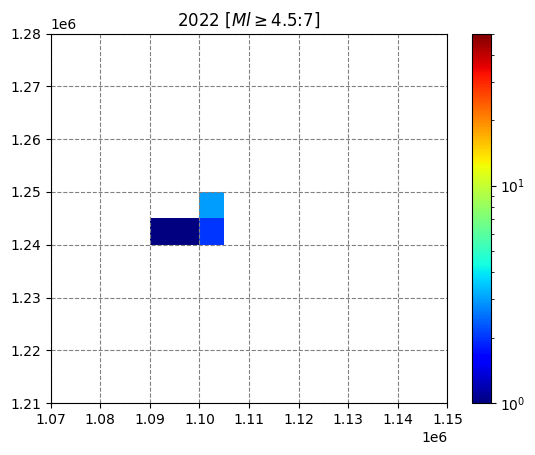

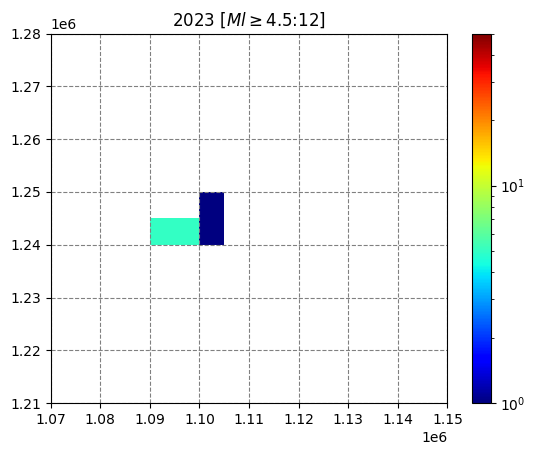

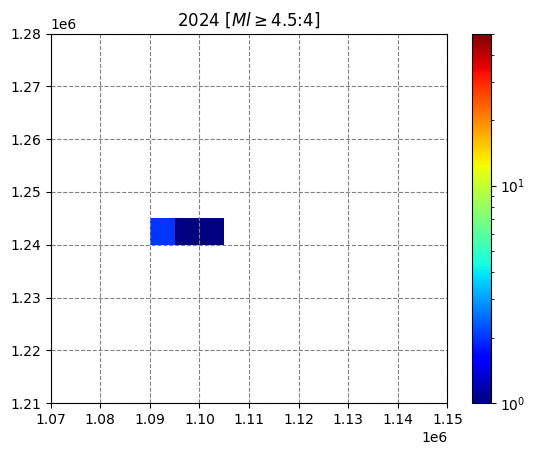

In [ ]:
years = np.arange(1994, 2025,1)

# [[xmin, xmax], [ymin, ymax]]
rangeHist2D = np.array([[1070000, 1150000],
                        [1210000, 1280000]])

# nx, ny
binsHist2d = [16, 14]

for year in years:
  gdf2 = gdf[gdf['Date-Time'].dt.year == year].copy()
  X = gdf2['X'].to_numpy()
  y = gdf2['Y'].to_numpy()
  nEventos = np.sum(gdf2['MAGNITUD Ml'] >= 4.5)

  plt.figure()
  plt.hist2d(X,
             y,
             bins=binsHist2d,
             range=rangeHist2D,
             norm='log', # "linear", "log", "symlog", "logit"
             vmin=1,
             vmax=50,
             cmap='jet')
  plt.grid(ls='--', c='grey')
  plt.colorbar()
  plt.title(f'{year} [$Ml\geq4.5$:{nEventos}]')
  plt.show()
  print('\n')

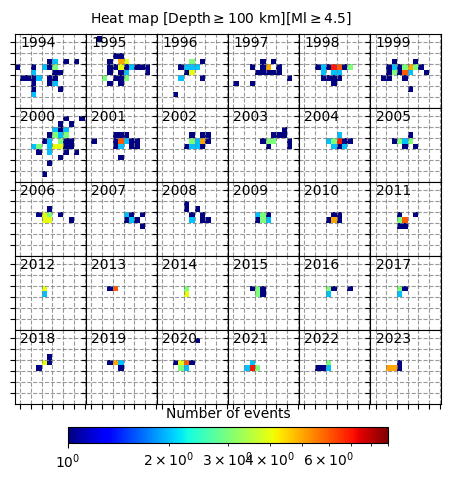

In [ ]:
years = np.arange(1994, 2025,1)

# [[xmin, xmax], [ymin, ymax]]
rangeHist2D = np.array([[1060000, 1150000],
                        [1200000, 1280000]])

# nx, ny
binsHist2d = [18, 16]

id_year = 0
fig, ax = plt.subplots(5,6,figsize=(5.5,6))
for i in range(5):
  for j in range(6):
    year = years[id_year]
    gdf2 = gdf[gdf['Date-Time'].dt.year == year].copy()
    X = gdf2['X'].to_numpy()
    y = gdf2['Y'].to_numpy()
    nEventos = np.sum(gdf2['MAGNITUD Ml'] >= 4.5)


    cm = ax[i,j].hist2d(X,
                   y,
                   bins=binsHist2d,
                   range=rangeHist2D,
                   norm='log', # "linear", "log", "symlog", "logit"
                   vmin=1,
                   vmax=9,
                   cmap='jet')
    ax[i,j].grid(ls='--', c='grey', alpha=0.8)
    ax[i,j].text(1080000, 1265000, str(year), size=10)
    ax[i,j].set_yticks(np.arange(1200000, 1280000, 10000))
    ax[i,j].set_xticks(np.arange(1060000, 1150000, 10000))
    ax[i,j].set_yticklabels([])
    ax[i,j].set_xticklabels([])
    ax[i,j].set_ylim(1210580, 1277080)
    ax[i,j].set_xlim(1074938, 1141140)
    id_year += 1
plt.subplots_adjust(wspace=0.0, hspace=0.0)
clb = plt.colorbar(cm[3], ax=ax.ravel().tolist(), location='bottom', pad=0.05, shrink=0.75)
clb.ax.set_title('Number of events', fontsize=10)
#plt.title(f'{year} [$Ml\geq4.5$:{nEventos}]')
plt.suptitle('Heat map [Depth$\geq$100 km][Ml$\geq$4.5]', fontsize=10, y=0.92)
plt.show()


In [ ]:
cm[3]

In [ ]:
ax.ravel().tolist()

[<Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >]

# End